# Table of contents
1. [Analysis Setup](#Analysis-setup)
   1. [User defined settings](#User-defined-settings)
   2. [Read in all models for analysis](#Read-in-all-models-for-analysis)
   3. [Basic input for plot features](#Basic-input-for-plot-features)
   4. [Import model results](#Import-model-results)
2. [Compile data](#Compile-data)
   1. [Assess (non)behavioral models](#Assess-(non)behavioral-models)
   2. [Assess model likelihoods](#Assess-model-likelihoods)
3. [Model analysis](#Model-analysis)
   1. [Calculate model likelihoods](#Calculate-model-likelihoods)
   2. [Define (non)behavioral models and compile statistics](#Define-(non)behavioral-models-and-compile-statistics)
   3. [Remove low likelihood models and recalculate likelihoods](#Remove-low-likelihood-models-and-recalculate-likelihoods)
   4. [Identify models of concerns (MOCs)](#Identify-models-of-concern)
4. [MOC analysis and calculations](#MOC-analysis-and-calculations)
   1. [Likelihood-weighted mean and standard deviation over ensemble](#Likelihood-weighted-mean-and-standard-deviation-over-ensemble)
   2. [Overlap of MOCs and other models at each location](#Overlap-of-MOCs-and-other-models-at-each-location)
   3. [Discriminatory index at each location](#Discriminatory-index-at-each-location)
   4. [Particle capture for each starting location](#Particle-capture-for-each-starting-location)
5. [Generate results](#Generate-results)
   1. [Reports](#Reports)
   2. [Head-related contour plots](#Head-related-contour-plots)
   3. [Particle-related contour plots](#Particle-related-contour-plots)
   4. [Transect plots along stream](#Transect-plots-along-stream)
   5. [Histograms at selected locations](#Histograms-at-selected-locations)
   6. [Save figures](#Save-figures)
6. [Retrieve head and flow data from truth and ML models](#Retrieve-head-and-flow-data-from-truth-and-ML-models)

## Analysis setup

**IMPORT PYTHON PACKAGES**   

In [1]:
# !pip install flopy==3.3.0
import flopy

import numpy as np

import os
import os.path
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

import warnings
import pickle
import time

import csv

warnings.simplefilter(action='ignore', category=UserWarning)                                          # suppress warnings related to older versions of some packages that we need to use to run flopy
warnings.simplefilter(action='ignore', category=RuntimeWarning)                                       # suppress warnings related to older versions of some packages that we need to use to run flopy


## User-defined settings
*Make changes here*


In [68]:
start = time.time()

stakeholder='ag'                                                                                      # choose from ag/town/env
stage='combine'                                                                                        # choose from random/reseed/combined/afterdata
prefix = stakeholder + '_' + stage + '_'      #generates filename prefix

def output_directory():     # use this to define where your output files reside
    os.chdir('c:\\Users\\moral\\OneDrive\\UofA\\2022-2023\\Research\\thesisCode_morales23\\basinModel\\currentModelOutput')       # 244 model rerun
    # os.chdir('/Users/roberthull/OneDrive/Workspace/Work/03_UA/03_Classwork/07_HWRS_582_GWModel/02_github/hws-rhull21/Assignment/TheBigChallenge/output/g_run1_244_04212021')       # 244 model base
    # os.chdir('/Users/roberthull/OneDrive/Workspace/Work/03_UA/03_Classwork/07_HWRS_582_GWModel/02_github/hws-rhull21/Assignment/TheBigChallenge/output/f 244 model')       # 244 model
    # os.chdir('/Users/roberthull/OneDrive/Workspace/Work/03_UA/03_Classwork/07_HWRS_582_GWModel/02_github/hws-rhull21/Assignment/TheBigChallenge/output/e 222 model')       # 222 model
    # os.chdir('/Users/roberthull/OneDrive/Workspace/Work/03_UA/03_Classwork/07_HWRS_582_GWModel/02_github/hws-rhull21/Assignment/TheBigChallenge/output/d 211 model')       # 211 model
    # os.chdir('/Users/roberthull/OneDrive/Workspace/Work/03_UA/03_Classwork/07_HWRS_582_GWModel/02_github/hws-rhull21/Assignment/TheBigChallenge/output/c common')       # common model

def figure_directory():     # use this to define where to put your figure files 
     os.chdir('c:\\Users\\moral\\OneDrive\\UofA\\2022-2023\\Research\\thesisCode_morales23\\basinModel\\figures')

def comparison_directory():
    os.chdir('c:\\Users\\moral\\OneDrive\\UofA\\2022-2023\\Research\\thesisCode_morales23\\basinModel\\likelihood')

displaycolumn=40                                                                                      # column for head and drawdown analysis
displayrow=30                                                                                         # row for head and drawdown analysis

# put obs well at town well
displaycolumn=20                                                                                      # column for head and drawdown analysis
displayrow=37                                                                                         # row for head and drawdown analysis

strdisplaycolumn=35                                                                                   # column for streamflow analysis

minmismatch=0.05                                                                                      # don't consider mismatches that are less than this value - avoids unrealistically high likelihoods
                                                                                                      # define criteria to meet to qualify as behavioral ... if a model PASSES this test it is behavioral
in_time_sequence =       [1,1,1]                                                                      # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
in_basis_sequence =      [0,0,1]                                                                      # see list below
in_comparison_sequence = [1,0,1]                                                                      # 0 = greater than, 1 = less than
in_limit_sequence =      [2000,10,3]                                                                  # value defining behavioral response
in_column_sequence =     [15,15,15]                                                                   # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
in_row_sequence =        [15,15,15]                                                                   # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used
                  
behavioral_criteria = [in_time_sequence, in_basis_sequence, in_comparison_sequence, in_limit_sequence, in_column_sequence, in_row_sequence]
comparison_directory()
np.save(prefix + 'behavioral_criteria',behavioral_criteria) #save behavioral criteria to a file
output_directory()

define_mocs = True                                                                                    # define criteria to meet to qualify as an MOC ... if a model PASSES this test it is a model of concern (MOC)
if stakeholder=='town':
    moc_time_sequence =       [2]                                                                       # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
    moc_basis_sequence =      [4]                                                                       # see list below
    moc_comparison_sequence = [0]                                                                       # 0 = greater than, 1 = less than
    moc_limit_sequence =      [0.5]                                                                   # value defining behavioral response
    moc_column_sequence =     [37]                                                                     # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
    moc_row_sequence =        [20]                                                                     # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used
elif stakeholder=='ag':
    moc_time_sequence =       [2]                                                                       # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
    moc_basis_sequence =      [3]                                                                       # see list below
    moc_comparison_sequence = [1]                                                                       # 0 = greater than, 1 = less than
    moc_limit_sequence =      [68]                                                                   # value defining behavioral response
    moc_column_sequence =     [13]                                                                     # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
    moc_row_sequence =        [11]                                                                     # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used
elif stakeholder=='env':
    moc_time_sequence =       [2]                                                                       # 0=ntna, 1=ytna, 2=ytya ... enter a number for each criterion applied
    moc_basis_sequence =      [2]                                                                       # see list below
    moc_comparison_sequence = [1]                                                                       # 0 = greater than, 1 = less than
    moc_limit_sequence =      [50]                                                                   # value defining behavioral response
    moc_column_sequence =     [38]                                                                     # column of observation point for basis 2 or 3  - must have a value for every criterion, even if not used
    moc_row_sequence =        [25]                                                                     # row of observation point for basis 2 or 3 - must have a value for every criterion, even if not used

# we should add the ability to have an MOC criterion in other than layer 1!!
# add criterion for flow reduction

#   BASES FOR DETERMINATION OF BEHAVIORAL MODEL
#       0 = max streamflow along stream
#       1 = min groundwater depth over first layer
#       2 = streamflow at specified location
#       3 = head at specified location
#       4 = drawdown at specified location
                                                                                                      # use empty brackets if no data available, each value must contain the same number of inputs, separate multiple data points by commas
moc_criteria = [moc_time_sequence, moc_basis_sequence, moc_comparison_sequence, moc_limit_sequence, moc_column_sequence, moc_row_sequence]
comparison_directory()
np.save(prefix + 'moc_criteria',moc_criteria) #save moc criteria to a file
output_directory()

read_true_data=False                                                                                   # True to read in the observations from truth_heads_ss_ytna.npy and truth_flows_ss_ytna.npy
if read_true_data==True:
    output_directory()
    trueheads_ss_ytna=np.load('truth_heads_ss_ytna.npy')[0][:][:]
    trueflows_ss_ytna=np.load('truth_strflow_ss_ytna.npy')[:]

usedata = False                                                                                        # set to true to use available data to calculate likelihoods, false to set models as equally likely
data_time_sequence = [1,1]                                                                            # 0 = ntna, 1 = ytna, 2 = ytya
data_basis_sequence =[1,1]                                                                            # identify head or flow observation
data_layer_sequence = [0,0]                                                                           # layer of head observation - enter zero for flow
data_column_sequence = [35,20]                                                                        # column of head or flow observation
data_row_sequence = [20,30]                                                                           # row of head or flow observation
data_value_sequence = np.zeros((np.shape(data_row_sequence)))
'''for ii in np.arange(np.shape(data_row_sequence)[0]):                                                              
    if data_basis_sequence[ii]==1:
        data_value_sequence[ii]=trueheads_ss_ytna[data_row_sequence[ii],data_column_sequence[ii]]     # Retrieve head data in top layer from the 'truth' model
    elif data_basis_sequence[ii]==0:
        data_value_sequence[ii]=trueflows_ss_ytna[data_column_sequence[ii]][1]                        # Retrieve flow data in stream from the 'truth' model'''
        
#   TYPES OF OBSERVATION DATA CONSIDERED
#       0 = streamflow at specified location
#       1 = head at specified location

if usedata==False:
    num_data=np.shape(data_time_sequence)[0]
else:
    num_data=0

eliminate_lowL_models=True                                                                            # True to eliminate low Likelihood models from the ensemble - for now, always set to true, but set number to eliminate to zero to turn off
lowLcut_percent=10                                                                                    # remove this percent of models with the lowest L values
lowLcut_number=0                                                                                      # don't remove any more than this number of models, no matter how low their L value, despite above limit
lowLlimit=0.05                                                                                        # don't remove models with an L higher than this, despite above limits
lowLecho=True                                                                                         # True to list the low L models, False to suppress (in case you have a lot!)

#Export files needed for multi-stakeholder comparisons:
#To import, use np.load()
comparison_directory()               #change directory to current stakeholder and stage
np.save(prefix + 'data_layer', data_layer_sequence)
np.save(prefix + 'data_row', data_row_sequence)
np.save(prefix + 'data_column', data_column_sequence)
output_directory()

# use the following to control which analyses are completed - may be useful when running partial analyses for many models
run_sections=1

# 0 = through identifying behavioral models and calculating model likelihoods
# 1 = identify models of concern
# 2 - calculate discriminatory index
# 3 - particle capture


Carried over variables

    in_time_sequence, in_basis_sequence, in_layer_sequence, in_column_sequence, in_value_sequence
    moc_time_sequence, moc_basis_sequence, moc_layer_sequence, moc_column_sequence, moc_value_sequence
    data_time_sequence, data_basis_sequence, data_layer_sequence, data_column_sequence, data_value_sequence
  
    define_mocs, usedata, eliminate_lowL_models, 
    displaycolumn, displayrow, strdisplaycolumn
    minmismatch
    lowLcut_percent, lowLcut_number, lowLlimit, lowLecho 
  
    num_data
  
    trueheads_ss_ytna, trueflows_ss_ytna

## Read in all models for analysis
*pulled from output directory*



In [69]:
files = os.listdir(os.curdir)                                                                         # all files in output directory
counter=-1                                                                                            # used to step through files
runcounter=-1                                                                                         # used to count number of steady state models 
t_runcounter=-1                                                                                       # used to count number of transient models
runnumbers=[]                                                                                         # file ids for steady state models
t_runnumbers=[]                                                                                       # file ids for transient models
holdtempvar=[]                                                                                        # previous model file analyzed - used to indicate next steady state model found
t_holdtempvar=[]                                                                                      # previous model file analyzed - used to indicate next transient model found

for f in files:                                                                                       # loop over all models in directory
    counter=counter+1
    if files[counter][0]=='m':                                                                        # only consider output model files
        try:                                                                                          # check for steady state models
            if files[counter][16]=='_':
                tempvar=files[counter][0:16]
                if counter==-1:
                    holdtempvar=tempvar
                elif holdtempvar!=tempvar: 
                    runcounter=runcounter+1
                    runnumbers.append(tempvar)                                                        # make a list of run names
                    holdtempvar=tempvar
        except:
            dummy=0
            
        try:                                                                                          # check for transient models
            if files[counter][16:26]=='_heads_pod':     
                t_tempvar=files[counter][0:16]
                if counter==-1:
                    t_holdtempvar=t_tempvar
                elif t_holdtempvar!=t_tempvar: 
                    t_runcounter=t_runcounter+1
                    t_runnumbers.append(t_tempvar)
                    t_holdtempvar=t_tempvar
        except:
            dummy=0
            
del counter                                                                                           # clear temporary variables
del runcounter
del t_runcounter
del holdtempvar
del t_holdtempvar

Carried over variables

    runnumbers, t_runnumbers

In [70]:
dir

<function dir>

## Basic input for plot features

In [71]:
run_params=np.zeros((np.shape(runnumbers)[0],7))                                                      # prepare an array to store parameter values that differ among model runs
for i in np.arange(np.shape(runnumbers)[0]):                                                          # loop over models to read parameter values from parvals file - not used for now, but may be
    with open (runnumbers[i]+'_parvals', 'rb') as fp:
        [nrow,ncol,delr,delc,Lx,Ly,nlay,ztop,crop,fNWc,well1,well2,recharge_ratio,return_loc,
             rNWc, K_horiz, Kzratio_low, Sy, R1, ET1, ETratio_riparian, Kratio_stream] = pickle.load(fp)
        run_params[i,0]=K_horiz
        run_params[i,1]=Kzratio_low
        run_params[i,2]=Sy
        run_params[i,3]=R1
        run_params[i,4]=ET1
        run_params[i,5]=ETratio_riparian
        run_params[i,6]=Kratio_stream

# assume well and recharge and return flow locations same for all runs and that the following are unchanged - eventually, include these in the parvals file
nreach = 48+1                                                                                         # number of reaches (# of cells in stream + 1 canal reach) 
strrow=25                                                                                             # row in which stream resides
reaches = np.arange(ncol-1)                                                                           # for plotting flow along stream
str_rows = strrow*np.ones((nreach),dtype=np.int32)                                                    # integer array of row #s for each stream reach 
str_cols = np.arange(1,nreach+1)                                                                      # integer array of col #s for each stream reach


Carried over variables

    run_params
    nreach, strrow, reaches, str_rows, str_cols

## Import model results

In [72]:
allheads_ss_ntna=np.zeros((len(runnumbers),50,50))                                                   # initialize arrays to accept all heads for each ss run
allheads_ss_ytna=np.zeros((len(runnumbers),50,50))
allheads_ss_ytya=np.zeros((len(runnumbers),50,50))
allbudgets_ss_ntna=np.zeros((len(runnumbers),16))                                                    # initialize arrays to accept all heads for each ss run
allbudgets_ss_ytna=np.zeros((len(runnumbers),16))
allbudgets_ss_ytya=np.zeros((len(runnumbers),16))
budget=np.zeros((7))
for i in range(len(runnumbers)):
    heads=np.load(runnumbers[i]+'_heads_ss_ntna.npy')[0][:][:]                                       # use heads in top layer
    allheads_ss_ntna[i][:][:]=heads
    heads=np.load(runnumbers[i]+'_heads_ss_ytna.npy')[0][:][:]
    allheads_ss_ytna[i][:][:]=heads
    heads=np.load(runnumbers[i]+'_heads_ss_ytya.npy')[0][:][:]
    allheads_ss_ytya[i][:][:]=heads
    budget=np.load(runnumbers[i]+'_budget_ss_ntna.npy')
    for j in np.arange(16):
        allbudgets_ss_ntna[i][j]=budget[j][1]
    budget=np.load(runnumbers[i]+'_budget_ss_ytna.npy')
    for j in np.arange(16):
        allbudgets_ss_ytna[i][j]=budget[j][1]
    budget=np.load(runnumbers[i]+'_budget_ss_ytya.npy')
    for j in np.arange(16):
        allbudgets_ss_ytya[i][j]=budget[j][1]

# budget components are:
# 0: STORAGE_IN
# 1: CONSTANT_HEAD_IN
# 2: WELLS_IN
# 3: ET_IN
# 4: RECHARGE_IN
# 5: STREAM_LEAKAGE_IN
# 6: TOTAL_IN
# 7: STORAGE_OUT
# 8: CONSTANT_HEAD_OUT
# 9: WELLS_OUT
#10: ET_OUT
#11: RECHARGE_OUT
#12: STREAM_LEAKAGE_OUT
#13: TOTAL_OUT
#14: IN-OUT
#15: PERCENT_DISCREPANCY

allheads_ss_ntna[allheads_ss_ntna<0]=0                                                               # remove the corners as they confused the standard deviation calculation
allheads_ss_ytna[allheads_ss_ytna<0]=0
allheads_ss_ytya[allheads_ss_ytya<0]=0

alldwt_ss_ntna=np.zeros((len(runnumbers),50,50))                                                     # initialize arrays to accept all water table depths for each ss run
alldwt_ss_ytna=np.zeros((len(runnumbers),50,50))     
alldwt_ss_ytya=np.zeros((len(runnumbers),50,50))     
maxdwt_ss_ntna=np.zeros((len(runnumbers)))                                                           # initialize arrays to accept maximum water table depth for each ss run
maxdwt_ss_ytna=np.zeros((len(runnumbers)))           
maxdwt_ss_ytya=np.zeros((len(runnumbers)))           

for i in np.arange(np.shape(allheads_ss_ntna)[0]):                                                   # calculate depths of the water table
    tempvar=allheads_ss_ntna[i,:,:]-ztop 
    alldwt_ss_ntna[i,:,:]=tempvar
    maxdwt_ss_ntna[i]=np.max(tempvar)
    tempvar=allheads_ss_ytna[i,:,:]-ztop 
    alldwt_ss_ytna[i,:,:]=tempvar
    maxdwt_ss_ytna[i]=np.max(tempvar)
    tempvar=allheads_ss_ytya[i,:,:]-ztop 
    alldwt_ss_ytya[i,:,:]=tempvar
    maxdwt_ss_ytya[i]=np.max(tempvar)

dd=allheads_ss_ytna-allheads_ss_ytya                                                                 # define drawdown for each model at each location in top layer from ytna and ytya 

allflows_ss_ntna=np.zeros((len(runnumbers),49))                                                      # initialize arrays to accept all flows for each ss run   
allflows_ss_ytna=np.zeros((len(runnumbers),49))
allflows_ss_ytya=np.zeros((len(runnumbers),49))
    
for i in range(len(runnumbers)):
    flows=np.load(runnumbers[i]+'_strflow_ss_ntna.npy')                                              # import flows at each stream cell across models for ntna
    flow = []
    for tup in range(len(flows)):
        flow.append(flows[tup][1])
    allflows_ss_ntna[i][:][:] = flow

    flows=np.load(runnumbers[i]+'_strflow_ss_ytna.npy')
    flow = []
    for tup in range(len(flows)):
        flow.append(flows[tup][1])
    allflows_ss_ytna[i][:][:]=flow
    
    flows=np.load(runnumbers[i]+'_strflow_ss_ytya.npy')
    flow = []
    for tup in range(len(flows)):
        flow.append(flows[tup][1])
    allflows_ss_ytya[i][:][:]=flow

allleaks_ss_ntna=np.zeros((len(runnumbers),49))                                                      # initialize arrays to accept all flows for each ss run   
allleaks_ss_ytna=np.zeros((len(runnumbers),49))
allleaks_ss_ytya=np.zeros((len(runnumbers),49))
    
for i in range(len(runnumbers)):
    leaks=np.load(runnumbers[i]+'_strleak_ss_ntna.npy')                                              # import leakage at each stream cell across models for ntna
    leak = []
    for tup in range(len(leaks)):
        leak.append(leaks[tup][1])
    allleaks_ss_ntna[i][:][:] = leak

    leaks=np.load(runnumbers[i]+'_strleak_ss_ytna.npy')
    leak = []
    for tup in range(len(leaks)):
        leak.append(leaks[tup][1])
    allleaks_ss_ytna[i][:][:]=leak
    
    leaks=np.load(runnumbers[i]+'_strleak_ss_ytya.npy')
    leak = []
    for tup in range(len(leaks)):
        leak.append(leaks[tup][1])
    allleaks_ss_ytya[i][:][:]=leak
    
testepts=np.load(runnumbers[0]+'_epts_ss_ytna.npy')                                                  # read this file to set dimensions of arrays in next lines
allepts_ss_ntna=np.zeros((np.shape(runnumbers)[0],np.shape(testepts)[0],np.shape(testepts)[1]))      # initialize arrays to accept all particle data for each ss run 
allepts_ss_ytna=np.zeros((np.shape(runnumbers)[0],np.shape(testepts)[0],np.shape(testepts)[1]))     
allepts_ss_ytya=np.zeros((np.shape(runnumbers)[0],np.shape(testepts)[0],np.shape(testepts)[1]))     

counter=-1
for i in runnumbers:                                       
    counter=counter+1                                                                                # count the models as loaded to form joint array with all models' results
    epts=np.load(i+'_epts_ss_ntna.npy')                                                              # load output for each model in ensemble
    
    for j in np.arange(np.shape(testepts)[0]):
        allepts_ss_ntna[counter,j,0]=epts[j][8]                                                      # start point column (all particles assumed to start in top layer, as recharge)
        allepts_ss_ntna[counter,j,1]=epts[j][7]                                                      # start point row 
        allepts_ss_ntna[counter,j,2]=epts[j][20]                                                     # end point column 
        allepts_ss_ntna[counter,j,3]=epts[j][19]                                                     # end point row 
        allepts_ss_ntna[counter,j,4]=epts[j][4]                                                      # end point time 
    epts=np.load(i+'_epts_ss_ytna.npy')  
    for j in np.arange(np.shape(testepts)[0]):
        allepts_ss_ytna[counter,j,0]=epts[j][8]            
        allepts_ss_ytna[counter,j,1]=epts[j][7]            
        allepts_ss_ytna[counter,j,2]=epts[j][20]           
        allepts_ss_ytna[counter,j,3]=epts[j][19]           
        allepts_ss_ytna[counter,j,4]=epts[j][4]       
    epts=np.load(i+'_epts_ss_ytya.npy')  
    for j in np.arange(np.shape(testepts)[0]):
        allepts_ss_ytya[counter,j,0]=epts[j][8]            
        allepts_ss_ytya[counter,j,1]=epts[j][7]            
        allepts_ss_ytya[counter,j,2]=epts[j][20]           
        allepts_ss_ytya[counter,j,3]=epts[j][19]          
        allepts_ss_ytya[counter,j,4]=epts[j][4]       
        
allflows_ss_ntna = np.delete(allflows_ss_ntna, return_loc,axis=1)                                    # remove reach used as canal to return town water to stream
allflows_ss_ytna = np.delete(allflows_ss_ytna, return_loc,axis=1)
allflows_ss_ytya = np.delete(allflows_ss_ytya, return_loc,axis=1)

del heads                                                                                            # clear temporary variables
del tempvar
del flow
del flows
del leak
del leaks
del testepts
del counter
del epts


Carried over variables

    allheads_ss_ntna, allheads_ss_ytna, allheads_ss_ytya
    allbudgets_ss_ntna, allbudgets_ss_ytna, allbudgets_ss_ytya
    allepts_ss_ntna, allepts_ss_ytna, allepts_ss_ytya


# Compile data

## Assess (non)behavioral models

In [73]:
cullmodels=np.zeros((np.shape(runnumbers)[0],50))                                                    # store values used to assess (non)behavioural and likelihood to check process
cullmodels_counter=-1

num_criteria=0
if 'in_time_sequence' in locals():
    num_criteria=np.shape(in_time_sequence)[0]                                                       # determine number of criteria to that have been applied

if num_criteria>0:
    print('Assessing (non)behavioral criteria')
    for ii in np.arange(num_criteria):                                                               # loop over bases for discrimination of models of concern or (non)behavioral models
        cullmodels_counter=cullmodels_counter+1
        print('Assessing criterion',ii)
        in_time=in_time_sequence[ii]
        in_basis=in_basis_sequence[ii]
        in_comparison=in_comparison_sequence[ii]
        in_limit=in_limit_sequence[ii]
        in_column=in_column_sequence[ii]
        in_row=in_row_sequence[ii]

        if in_basis==0:
            in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))
            if in_time==0:
                in_metric=np.max(allflows_ss_ntna,axis=1)                                            # store maximum flow for each model for ntna case
            elif in_time==1:
                in_metric=np.max(allflows_ss_ytna,axis=1)                                            # store maximum flow for each model for ytna case
            else:
                in_metric=np.max(allflows_ss_ytya,axis=1)                                            # store maximum flow for each model for ytya case
        elif in_basis==1:
            in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))     
            if in_time==0:
                in_metric=maxdwt_ss_ntna                                                             # store minimum flow for each model for ntna case
            elif in_time==1:
                in_metric=maxdwt_ss_ytna                                                             # store minimum flow for each model for ytna case
            else:
                in_metric=in_metric=maxdwt_ss_ytya                                                   # store minimum flow for each model for ytya case
        elif in_basis==2:
            in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))     
            if in_time==0:
                for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                    in_metric[j]=allflows_ss_ntna[j][in_column]                                      # store flow at specified location for each model for ntna case
            elif in_time==1:
                for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                    in_metric[j]=allflows_ss_ytna[j][in_column]                                      # store flow at specified location for each model for ntna case
            else:
                for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                    in_metric[j]=allflows_ss_ytya[j][in_column]                                      # store flow at specified location for each model for ntna case
        elif in_basis==3:
            in_metric=np.zeros((np.shape(allheads_ss_ntna)[0]))     
            if in_time==0:
                for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                    in_metric[j]=allheads_ss_ntna[j][in_row][in_column]                              # store flow at specified location for each model for ntna case
            elif in_time==1:
                for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                    in_metric[j]=allheads_ss_ytna[j][in_row][in_column]                              # store flow at specified location for each model for ntna case
            else:
                for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                    in_metric[j]=allheads_ss_ytya[j][in_row][in_column]                              # store flow at specified location for each model for ntna case
        else:
            in_metric=np.zeros((np.shape(dd)[0]))     
            if in_time==0:
                for j in np.arange(np.shape(dd)[0]):                
                    in_metric[j]=dd[j][in_row][in_column]                                            # store flow at specified location for each model for ntna case
            elif in_time==1:
                for j in np.arange(np.shape(dd)[0]):                
                    in_metric[j]=dd[j][in_row][in_column]                                            # store flow at specified location for each model for ntna case
            else:
                for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                    in_metric[j]=dd[j][in_row][in_column]                                            # store flow at specified location for each model for ntna case

        cullmodels[:,cullmodels_counter]=in_metric                                                   # store data used to check (non)behavioral status

    del num_criteria                                                                                 # clear temporary variables
    del in_time
    del in_basis
    del in_comparison
    del in_limit
    del in_column
    del in_row
    del in_metric

else:
    print('No (non)behavioral criteria listed')
    

Assessing (non)behavioral criteria
Assessing criterion 0
Assessing criterion 1
Assessing criterion 2


Carried over variables

    cullmodels, cullmodels_counter


## Assess model likelihoods

In [74]:
num_data=0

In [75]:
startdata=cullmodels_counter+1                                                                     # index in cullmodels that is start of data for likelihood estimation
holdfordataworth=np.zeros((num_data,np.shape(allflows_ss_ntna)[0]))
if usedata==True:
    num_data=np.shape(data_time_sequence)[0]
    if num_data>0:                                                                                 # if there are data for comparison, calculate likelihoods
        for jj in np.arange(np.shape(allflows_ss_ntna)[0]):   
            for ii in np.arange(num_data):                                                         # loop over bases for discrimination
                in_basis=data_basis_sequence[ii]
                in_time=data_time_sequence[ii]
                if in_basis==0:                                                                    # note that squared mismatch sums over all observations
                    if in_time==0:
                        data2check=allflows_ss_ntna[jj][data_row_sequence[ii]][data_column_sequence[ii]]
                    elif in_time==1:
                        data2check=allflows_ss_ytna[jj][data_row_sequence[ii]][data_column_sequence[ii]]
                    else:
                        data2check=allflows_ss_ytya[jj][data_row_sequence[ii]][data_column_sequence[ii]]
                else:
                    if in_time==0:
                        data2check=allheads_ss_ntna[jj][data_row_sequence[ii]][data_column_sequence[ii]]
                    elif in_time==1:
                        data2check=allheads_ss_ytna[jj][data_row_sequence[ii]][data_column_sequence[ii]]
                    else:
                        data2check=allheads_ss_ytya[jj][data_row_sequence[ii]][data_column_sequence[ii]]        
                cullmodels[jj,cullmodels_counter+1+ii]=data2check
                holdfordataworth[ii,jj]=data2check
        del in_time                                                                                # clear temporary variables
        del in_basis
        del data2check
        np.save(prefix + 'holdfordataworth', holdfordataworth)

    else:     
        dummy=0
        del dummy


Carried over variables

    startdata
    cullmodels, cullmodels_counter
    


# Model analysis

## Calculate model likelihoods
*set nonbehavioral to low L*

In [76]:
rmse=np.zeros((np.shape(runnumbers)[0]))                                                          # use model rmse to flag nonbehavioral models below
L = 1/np.shape(allflows_ss_ntna)[0]                                                               # set likelihoods equal if there as default, keep if there are no data
L=np.tile(L,np.shape(allflows_ss_ntna)[0])
if usedata==True:
    if np.shape(data_time_sequence)[0]>0:
        cullmodels_counter=cullmodels_counter+num_data                                            # need to advance counter here because of looping structure above
        mmsqsum=0
        for i in np.arange(np.shape(data_time_sequence)[0]):                                      # loop over number of data used to calculate L
            cullmodels_counter=cullmodels_counter+1
            mmsq=((cullmodels[:,i+startdata]-data_value_sequence[i])**2)                          # square mismatch for first data point
            cullmodels[:,cullmodels_counter]=mmsq                                                 # store square mismatches for later checking
            mmsqsum=mmsqsum+mmsq                                                                  # sum square mismatches
        rmse=(mmsqsum/(i+1))**0.5                                                                 # calculate root mean square mismatch

        cullmodels_counter=cullmodels_counter+1
        cullmodels[:,cullmodels_counter]=rmse                                                     # store rmse
        for i in np.arange(np.shape(in_time_sequence)[0]):                                        # set likelihoods of nonbehavioral models to near-zero by setting rmse very high
            if in_comparison_sequence[i]==0:
                rmse[cullmodels[:,i]<=in_limit_sequence[i]]=1.2345e9
            else:
                rmse[cullmodels[:,i]>=in_limit_sequence[i]]=1.2345e9
        cullmodels_counter=cullmodels_counter+1
        cullmodels[:,cullmodels_counter]=rmse                                                     # store rmse after culling non-behavioral models
        Ltemp=1/rmse                                                                              # invert rmse as first step to calculating L
        L=Ltemp/np.sum(Ltemp)
        cullmodels_counter=cullmodels_counter+1
        cullmodels[:,cullmodels_counter]=L                                                        # calculate and store L
        del mmsq                                                                                          # clear temporary variables
        del mmsqsum
        del Ltemp
else:
    for i in np.arange(np.shape(in_time_sequence)[0]):                                            # set likelihoods of nonbehavioral models to near-zero by setting rmse very high
        if in_comparison_sequence[i]==0:
            rmse[cullmodels[:,i]<=in_limit_sequence[i]]=1.2345e9
        else:
            rmse[cullmodels[:,i]>=in_limit_sequence[i]]=1.2345e9
sorted_L_behavioral=np.sort(L)[::-1]



In [77]:
print(np.shape(L))
np.sort(L)[::-1]



(25,)


array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04])

Carried over variables

    rmse, L, sorted_L_behavioral
    cullmodels, cullmodels_counter


## Define (non)behavioral models and compile statistics

In [78]:
behavioral_ids=[]
nonbehavioral_ids=[]
behavioral_ids_index=[]
nonbehavioral_ids_index=[]
tempvar=1*(rmse==1.2345e9)

for i in np.arange(np.shape(tempvar)[0]):
    if tempvar[i]==0:
        behavioral_ids.append(runnumbers[i])
        behavioral_ids_index.append(i)
    else:
        nonbehavioral_ids.append(runnumbers[i])
        nonbehavioral_ids_index.append(i)

holdplotx=[]                                                                                      # store values for later plotting
holdploty=[]
holdleftlimit=[]
holdrightlimit=[]
holdplottype=[]

num_criteria=0
counter=-1

if 'in_time_sequence' in locals():
    num_criteria=np.shape(in_time_sequence)[0]                                                    # determine number of criteria to that have been applied

if num_criteria>0:
    for ii in np.arange(num_criteria):                                                            # loop over bases for discrimination of models of concern or (non)behavioral models
        in_comparison=in_comparison_sequence[ii]
        sorted_in_metric=np.sort(cullmodels[:,ii])[::-1]                                          # sort metric in decreasing order for plotting

        # save results to plot later
        plottype=0                                                                                # distinguish behavioral (0) and MOC (1) plots
        holdplottype.append(plottype)
        holdplotx.append(np.arange(np.shape(sorted_in_metric)[0]))                                # store ordinal numbers from 0 to number of models
        holdploty.append(sorted_in_metric)                                                        # hold sorted values of the metric used for assessment, high to low
        if in_comparison==0:                                                                      # greater than indicates behavioral
            holdleftlimit.append(np.shape(behavioral_ids)[0])                                     # limits of behavioral models for sorted plot
            holdrightlimit.append(np.shape(sorted_in_metric)[0])
        elif in_comparison==1:                                                                    # less than indicates behavioral
            holdleftlimit.append(0)
            holdrightlimit.append(np.shape(sorted_in_metric)[0]-np.shape(behavioral_ids)[0])
   
    if np.shape(nonbehavioral_ids)[0]>0:                                                          # assess prevalence of each parameter for in and not-in groups
        tempvar=[]
        b_meanid=np.zeros(7)
        b_varid=np.zeros(7)
        for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
            tempvar=np.zeros(len(behavioral_ids_index))                                           # establish array with size equal to number of behavioral models
            counter=-1
            for j in (behavioral_ids_index):                                                      # count over behavioral models
                counter=counter+1
                tempvar[counter]= int(runnumbers[j][i])                                           # store digit from model number
            b_meanid[i-9]=np.mean(tempvar)                                                        # find mean of each digit
            b_varid[i-9]=np.std(tempvar)                                                          # find standard deviation over each digit
        tempvar=[]
        nonb_meanid=np.zeros(7)
        nonb_varid=np.zeros(7)
        for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
            tempvar=np.zeros(len(nonbehavioral_ids_index))
            counter=-1
            for j in (nonbehavioral_ids_index):                                                   # count over models that exceed max flow
                counter=counter+1
                tempvar[counter]= int(runnumbers[counter][i])                                     # store digit from model number
            nonb_meanid[i-9]=np.mean(tempvar)                                                     # find mean of each digit
            nonb_varid[i-9]=np.std(tempvar)                                                       # find standard deviation over each digit
        nonb_meanid=np.round(nonb_meanid*1000)/1000                                               # truncate for better presentation in table
        nonb_varid=np.round(nonb_varid*1000)/1000                
    else:
        print('All models are behavioral')

    del num_criteria                                                                              # clear temporary variables
    del tempvar
    del counter
    del plottype
    del sorted_in_metric

else:
    print('No (non)behavioral criteria listed')
    


Carried over variables

    behavioral_ids, nonbehavioral_ids, behavioral_ids_index, nonbehavioral_ids_index
    holdplotx, holdploty, holdleftlimit, holdrightlimit, holdplottype
    b_meanid, b_varid, nonb_meanid, nonb_varid


## Remove low likelihood models and recalculate likelihoods

In [79]:
eliminate_lowL_models=True                                                                            # True to eliminate low Likelihood models from the ensemble - for now, always set to true, but set number to eliminate to zero to turn off
lowLcut_percent=10                                                                                    # remove this percent of models with the lowest L values
lowLcut_number=0                                                                                      # don't remove any more than this number of models, no matter how low their L value, despite above limit
lowLlimit=0.05                                                                                        # don't remove models with an L higher than this, despite above limits
lowLecho=True                                                                                         # True to list the low L models, False to suppress (in case you have a lot!)

In [80]:
sorted_L=np.sort(L)[::-1]
if eliminate_lowL_models==True:
    Lcut_ids=np.argsort(L)                                                                        # sort model indices by L, increasing
    Lcut_vals=np.sort(L)
    numtoremove=int(np.shape(L)[0]*(lowLcut_percent)/100)+np.shape(nonbehavioral_ids)[0]          # find number of models represented by % to remove
    checkLlimit=np.sum(Lcut_vals<lowLlimit)                                                       # don't cut models with L above lowLlimit
    numtoremove=min(checkLlimit,numtoremove)
    numtoremove=min(numtoremove,lowLcut_number)                                                   # don't allow number to remove to pass number limit
    Lcut_ids=Lcut_ids[0:numtoremove]     
    rmse[Lcut_ids]=1.23456e9
    Ltemp=1/rmse                                                                                  # invert rmse as first step to calculating L
    
#     print(nonbehavioral_ids_index)
#     print(Ltemp)
#     Ltemp[nonbehavioral_ids_index]=1/1.23456e9
#     print(Ltemp)

    L=Ltemp/np.sum(Ltemp)

    cullmodels_counter=cullmodels_counter+1
    cullmodels[:,cullmodels_counter]=L                                                            # store data used to check (non)behavioral status

# UNCOMMENT THE FOLLOWING TO DELETE RESULTS RATHER THAN JUST SETTING TO VERY LOW L
#     excludemodels1=rmse==1.23456e9
#     excludemodels1=1*excludemodels
#     excludemodels2=(np.arange(np.shape(runnumbers)[0]))
#     excludemodels=excludemodels2[excludemodels1==1]
#     for i in np.arange(np.shape(excludemodels)[0]):                                             # delete non-behavioral models
#         del runnumbers[excludemodels[i]]
#         allheads_ss_ntna = np.delete(allheads_ss_ntna, excludemodels[i],axis=0)                 # remove calculation rows for excluded models
#         allheads_ss_ytna = np.delete(allheads_ss_ytna, excludemodels[i],axis=0)
#         allheads_ss_ytya = np.delete(allheads_ss_ytya, excludemodels[i],axis=0)
#         allflows_ss_ntna = np.delete(allflows_ss_ntna, excludemodels[i],axis=0)
#         allflows_ss_ytna = np.delete(allflows_ss_ytna, excludemodels[i],axis=0)
#         allflows_ss_ytya = np.delete(allflows_ss_ytya, excludemodels[i],axis=0)
#         allleaks_ss_ntna = np.delete(allleaks_ss_ntna, excludemodels[i],axis=0)
#         allleaks_ss_ytna = np.delete(allleaks_ss_ytna, excludemodels[i],axis=0)
#         allleaks_ss_ytya = np.delete(allleaks_ss_ytya, excludemodels[i],axis=0)
#         allepts_ss_ntna = np.delete(allepts_ss_ntna, excludemodels[i],axis=0)            
#         dd = np.delete(dd, excludemodels[i],axis=0)     
#         run_params = np.delete(run_params, excludemodels[i],axis=0)                             # remove model names from list, too 

    del numtoremove                                                                                   # clear temporary variables
    del checkLlimit
    del Ltemp
    del Lcut_vals


Carried over variables

    Lcut_ids
    rmse, L
    cullmodels, cullmodels_counter


## Identify models of concern (MOCs)

In [81]:
# remember to remove nonbehavioral models from MOCs and from other models

if run_sections>0:
    if define_mocs==True:
        moc_total=np.zeros((np.shape(runnumbers)[0]))
        num_criteria=np.shape(moc_time_sequence)                                                      # determine number of criteria to apply    
        for ii in np.arange(num_criteria[0]):                                                         # loop over bases for discrimination of models of concern or (non)behavioral models
            print('Assessing model of concern criterion',ii)
            in_time=moc_time_sequence[ii]
            in_basis=moc_basis_sequence[ii]
            in_comparison=moc_comparison_sequence[ii]
            in_limit=moc_limit_sequence[ii]
            in_column=moc_column_sequence[ii]
            in_row=moc_row_sequence[ii]

            if in_basis==0:
                in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))
                if in_time==0:
                    in_metric=np.max(allflows_ss_ntna,axis=1)                                         # store maximum flow for each model for ntna case
                elif in_time==1:
                    in_metric=np.max(allflows_ss_ytna,axis=1)           
                else:
                    in_metric=np.max(allflows_ss_ytya,axis=1)           
            elif in_basis==1:
                in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))     
                if in_time==0:
                    in_metric=maxdwt_ss_ntna                                                          # store minimum flow for each model for ntna case
                elif in_time==1:
                    in_metric=maxdwt_ss_ytna                            
                else:
                    in_metric=in_metric=maxdwt_ss_ytya                  
            elif in_basis==2:
                in_metric=np.zeros((np.shape(allflows_ss_ntna)[0]))     
                if in_time==0:
                    for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                        in_metric[j]=allflows_ss_ntna[j][in_column]                                   # store flow at specified location for each model for ntna case
                elif in_time==1:
                    for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                        in_metric[j]=allflows_ss_ytna[j][in_column]    
                else:
                    for j in np.arange(np.shape(allflows_ss_ytna)[0]):                
                        in_metric[j]=allflows_ss_ytya[j][in_column]    
            elif in_basis==3:
                in_metric=np.zeros((np.shape(allheads_ss_ntna)[0]))     
                if in_time==0:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=allheads_ss_ntna[j][in_row][in_column]                           # store head at specified location for each model for ntna case
                elif in_time==1:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=allheads_ss_ytna[j][in_row][in_column]    
                else:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=allheads_ss_ytya[j][in_row][in_column]    
            else:
                in_metric=np.zeros((np.shape(dd)[0]))     
                if in_time==0:
                    for j in np.arange(np.shape(dd)[0]):                
                        in_metric[j]=dd[j][in_row][in_column]                                         # store drawdown at specified location for each model for ntna case
                elif in_time==1:
                    for j in np.arange(np.shape(dd)[0]):                
                        in_metric[j]=dd[j][in_row][in_column]    
                else:
                    for j in np.arange(np.shape(allheads_ss_ytna)[0]):                
                        in_metric[j]=dd[j][in_row][in_column]    

            cullmodels_counter=cullmodels_counter+1
            cullmodels[:,cullmodels_counter]=in_metric                                                # store data used to check (non)behavioral status
            cullmodels_counter=cullmodels_counter+1
            cullmodels[:,cullmodels_counter]=1*(in_metric>in_limit)                                   # default for in_comparison = 0 ... 1 signifies an MOC, 0 an other model
            if in_comparison==1:
                cullmodels[:,cullmodels_counter]=1-cullmodels[:,cullmodels_counter]
            moc_total=moc_total+cullmodels[:,cullmodels_counter]    
            nummocs=np.sum(cullmodels[:,cullmodels_counter])

            sorted_in_metric=np.sort(in_metric)[::-1]                                                 # sort metric in decreasing order over all models

            # save results to plot later
            plottype=1
            holdplottype.append(plottype)
            holdplotx.append(np.arange(np.shape(runnumbers)[0]))                                      # store ordinal numbers from 0 to number of criteria used for assessing models
            holdploty.append(sorted_in_metric)                                                        # hold sorted values of the metric used for assessment, high to low
            if in_comparison==0:                                                                      # greater than indicates behavioral
                holdleftlimit.append(nummocs)                                                         # model zero presumably behavioral
                holdrightlimit.append(np.shape(runnumbers)[0])
            elif in_comparison==1:
                holdleftlimit.append(0)
                holdrightlimit.append(np.shape(runnumbers)[0]-nummocs)

        cullmodels_counter=cullmodels_counter+1
        cullmodels[:,cullmodels_counter]=moc_total
        np.savetxt("cullmodels.csv", cullmodels, delimiter=",")                                       # output this file to check all analyses to this point manually

        moc_ids=[]
        other_ids=[]
        moc_ids_counter=[]
        other_ids_counter=[]
        for i in np.arange(np.shape(runnumbers)[0]):                                                  # loop over all models
            if moc_total[i]>0:
                moc_ids.append(runnumbers[i])
                moc_ids_counter.append(i)
            else:
                other_ids.append(runnumbers[i])                                                       # store names of other models
                other_ids_counter.append(i)

        moc_ids=[x for x in moc_ids if not x in nonbehavioral_ids]
        other_ids=[x for x in other_ids if not x in nonbehavioral_ids]

        if np.shape(moc_ids)[0]>0:                                                                  # Assess prevalence of each parameter on in and not-in groups
            tempvar=[]
            moc_meanid=np.zeros(7)
            moc_varid=np.zeros(7)
            for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
                tempvar=np.zeros(len(moc_ids))
                counter=-1
                for j in (moc_ids):                                                                   # count over models that exceed max flow
                    counter=counter+1
                    tempvar[counter]= int(runnumbers[counter][i])                                     # store digit from model number
                moc_meanid[i-9]=np.mean(tempvar)                                                      # find mean of each digit
                moc_varid[i-9]=np.std(tempvar)                                                        # find standard deviation over each digit
            moc_meanid=np.round(moc_meanid*1000)/1000
            tempvar=[]
            other_meanid=np.zeros(7)
            other_varid=np.zeros(7)
            for i in np.arange(9,16):                                                                 # count over parameters that are varied in models that exceed max flow
                tempvar=np.zeros(len(other_ids))
                counter=-1
                for j in (other_ids):                                                                 # count over models that exceed max flow
                    counter=counter+1
                    tempvar[counter]= int(runnumbers[counter][i])                                     # store digit from model number
                other_meanid[i-9]=np.mean(tempvar)                                                    # find mean of each digit
                other_varid[i-9]=np.std(tempvar)                                                      # find standard deviation over each digit
            other_meanid=np.round(other_meanid*1000)/1000
        else:
            print('No models of concern')

    if 'tempvar' in locals():
        del tempvar                                                                                       # clear temporary variables
        del counter
    # del in_metric
    # del in_time
    # del in_basis
    # del in_comparison
    # del in_limit
    # del in_column
    # del in_row
    # del num_criteria

    #Export files needed for multi-stakeholder comparisons:
    #To import, use np.load()
    comparison_directory()               #change directory to current stakeholder and stage
    np.save(prefix + 'runnumbers', runnumbers)
    np.save(prefix +'sorted_L', sorted_L)
    np.save(prefix +'L', L)
    np.save(prefix +'moc_ids_counter', moc_ids_counter)
    output_directory()


Assessing model of concern criterion 0


Carried over variables

    moc_total, nummocs
        
    sorted_in_metric
    holdplotx, holdploty, holdleftlimit, holdrightlimit, holdplottype
    
    b_meanid, b_varid, nonb_meanid, nonb_varid
    moc_ids, other_ids, moc_ids_counter, other_ids_counter
    moc_meanid, moc_varid, other_meanid, other_varid
    
    rmse, L
    cullmodels, cullmodels_counter


# MOC analysis and calculations

## Likelihood-weighted mean and standard deviation over ensemble

In [82]:
if run_sections>-1:
    def Lstats(Lin,datain):                                                                           # this function calculates the likelihood weighted mean and standard deviation, defaults to normal mean and std if no data available
        tempout=[]
        if np.ndim(datain)==3:                                                                        # used to differentiate head and stream data by dimensionality
            tempmeanmatrix=np.zeros((np.shape(datain)[1],np.shape(datain)[2]))                        # set up array to store mean over all data
            tempstdmatrix=np.zeros((np.shape(datain)[1],np.shape(datain)[2]))                         # set up array to store standard deviation over all data
        elif np.ndim(datain)==2:
            tempmeanmatrix=np.zeros((np.shape(datain)[1]))
            tempstdmatrix=np.zeros((np.shape(datain)[1]))
        else:                                                                                         # kill the program if the data has neither 2 nor 3 dimensions
            print('problem with an input file')
            die
        for j in np.arange(np.shape(datain)[1]):
            if np.ndim(datain)==3:                                                                    # treat 2 and 3 dimensional data differently
                for k in np.arange(np.shape(datain)[2]):
                    tempvar=datain[:,j,k]
                    tempmeanval=np.sum(tempvar*Lin)/np.sum(Lin)                                       # calculate L-weighted mean over all models at each location
                    tempmeanmatrix[j,k]=tempmeanval
                    meanremove=np.repeat(tempmeanval,np.shape(tempvar)[0])
                    tempstdmatrix[j,k]=(np.sum(Lin*(tempvar-meanremove)**2)/(np.sum(Lin)*
                        (np.shape(Lin)[0]-1)/np.shape(Lin)[0]))**0.5                                  # calculate L-weighted standard deviation over all models at each location
            else:
                tempvar=datain[:,j]
                tempmeanval=np.sum(tempvar*Lin)/np.sum(Lin)
                tempmeanmatrix[j]=tempmeanval
                meanremove=np.repeat(tempmeanval,np.shape(tempvar)[0])
                tempstdmatrix[j]=(np.sum(Lin*(tempvar-meanremove)**2)/(np.sum(Lin)*
                     (np.shape(Lin)[0]-1)/np.shape(Lin)[0]))**0.5
        tempout.append(tempmeanmatrix)                                                                # export matrix of L-weighted means over all models at each point
        tempout.append(tempstdmatrix)                                                                 # export matrix of L-weighted standard deviations over all models at each point
        del tempmeanval                                                                               # clear temporary variables
        del meanremove
        del tempvar
        del tempmeanmatrix
        del tempstdmatrix
        return tempout


    bestmodels=np.argsort(-L)
    MLmodelID=bestmodels[0]

    # remember to add calculations for budget elements
    tempout=Lstats(L,allheads_ss_ntna)                                                                # call the function to calculate the L weighted mean and std
    headmean_ss_ntna=tempout[0]                                                                       # store the mean
    headvar_ss_ntna=tempout[1]                                                                        # store the standard deviation
    headML_ss_ntna=allheads_ss_ntna[bestmodels[0]]
    tempout=Lstats(L,allheads_ss_ytna)
    headmean_ss_ytna=tempout[0]
    headML_ss_ytna=allheads_ss_ytna[bestmodels[0]]
    headvar_ss_ytna=tempout[1]
    tempout=Lstats(L,allheads_ss_ytya)
    headmean_ss_ytya=tempout[0]
    headML_ss_ytya=allheads_ss_ytya[bestmodels[0]]
    headvar_ss_ytya=tempout[1]
    tempout=Lstats(L,dd)
    ddmean=tempout[0]
    ddvar=tempout[1]
    tempout=Lstats(L,allleaks_ss_ntna)
    leakmean_ss_ntna=tempout[0]
    leakvar_ss_ntna=tempout[1]
    tempout=Lstats(L,allleaks_ss_ytna)
    leakmean_ss_ytna=tempout[0]
    leakvar_ss_ytna=tempout[1]
    tempout=Lstats(L,allleaks_ss_ytya)
    leakmean_ss_ytya=tempout[0]
    leakvar_ss_ytya=tempout[1]
    tempout=Lstats(L,allflows_ss_ntna)
    flowmean_ss_ntna=tempout[0]
    flowML_ss_ntna=allflows_ss_ntna[bestmodels[0]]
    flowvar_ss_ntna=tempout[1]
    tempout=Lstats(L,allflows_ss_ytna)
    flowmean_ss_ytna=tempout[0]
    flowML_ss_ytna=allflows_ss_ytna[bestmodels[0]]
    flowvar_ss_ytna=tempout[1]
    tempout=Lstats(L,allflows_ss_ytya)
    flowmean_ss_ytya=tempout[0]
    flowML_ss_ytya=allflows_ss_ytya[bestmodels[0]]
    flowvar_ss_ytya=tempout[1]

if run_sections>0:
    # calculate L-weighted stats for MOCs and other models, if defined
    if define_mocs==True and np.shape(moc_ids_counter)[0] > 0:
        tempout=Lstats(L[moc_ids_counter],allheads_ss_ntna[moc_ids_counter])
        moc_headmean_ss_ntna=tempout[0]
        moc_headvar_ss_ntna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allheads_ss_ytna[moc_ids_counter])
        moc_headmean_ss_ytna=tempout[0]
        moc_headvar_ss_ytna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allheads_ss_ytya[moc_ids_counter])
        moc_headmean_ss_ytya=tempout[0]
        moc_headvar_ss_ytya=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allleaks_ss_ntna[moc_ids_counter])
        moc_leakmean_ss_ntna=tempout[0]
        moc_leakvar_ss_ntna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allleaks_ss_ytna[moc_ids_counter])
        moc_leakmean_ss_ytna=tempout[0]
        moc_leakvar_ss_ytna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allleaks_ss_ytya[moc_ids_counter])
        moc_leakmean_ss_ytya=tempout[0]
        moc_leakvar_ss_ytya=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allflows_ss_ntna[moc_ids_counter])
        moc_flowmean_ss_ntna=tempout[0]
        moc_flowvar_ss_ntna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allflows_ss_ytna[moc_ids_counter])
        moc_flowmean_ss_ytna=tempout[0]
        moc_flowvar_ss_ytna=tempout[1]
        tempout=Lstats(L[moc_ids_counter],allflows_ss_ytya[moc_ids_counter])
        moc_flowmean_ss_ytya=tempout[0]
        moc_flowvar_ss_ytya=tempout[1]

        tempout=Lstats(L[other_ids_counter],allheads_ss_ntna[other_ids_counter])
        other_headmean_ss_ntna=tempout[0]
        other_headvar_ss_ntna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allheads_ss_ytna[other_ids_counter])
        other_headmean_ss_ytna=tempout[0]
        other_headvar_ss_ytna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allheads_ss_ytya[other_ids_counter])
        other_headmean_ss_ytya=tempout[0]
        other_headvar_ss_ytya=tempout[1]
        tempout=Lstats(L[other_ids_counter],allleaks_ss_ntna[other_ids_counter])
        other_leakmean_ss_ntna=tempout[0]
        other_leakvar_ss_ntna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allleaks_ss_ytna[other_ids_counter])
        other_leakmean_ss_ytna=tempout[0]
        other_leakvar_ss_ytna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allleaks_ss_ytya[other_ids_counter])
        other_leakmean_ss_ytya=tempout[0]
        other_leakvar_ss_ytya=tempout[1]
        tempout=Lstats(L[other_ids_counter],allflows_ss_ntna[other_ids_counter])
        other_flowmean_ss_ntna=tempout[0]
        other_flowvar_ss_ntna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allflows_ss_ytna[other_ids_counter])
        other_flowmean_ss_ytna=tempout[0]
        other_flowvar_ss_ytna=tempout[1]
        tempout=Lstats(L[other_ids_counter],allflows_ss_ytya[other_ids_counter])
        other_flowmean_ss_ytya=tempout[0]
        other_flowvar_ss_ytya=tempout[1]

    del tempout                                                                                       # clear temporary variables
    del bestmodels


Carried over variables

    headmean_ss_ntna, headmean_ss_ytna, headmean_ss_ytya
    headvar_ss_ntna, headvar_ss_ytna, headvar_ss_ytya
    leakmean_ss_ntna, leakmean_ss_ytna, leakmean_ss_ytya
    leakvar_ss_ntna, leakvar_ss_ytna, leakvar_ss_ytya
    flowmean_ss_ntna, flowmean_ss_ytna, flowmean_ss_ytya
    flowvar_ss_ntna, flowvar_ss_ytna, flowvar_ss_ytya
    
    dd_mean, dd_var
        
    moc_headmean_ss_ntna, moc_headmean_ss_ytna, moc_headmean_ss_ytya
    moc_headvar_ss_ntna, moc_headvar_ss_ytna, moc_headvar_ss_ytya
    moc_leakmean_ss_ntna, moc_leakmean_ss_ytna, moc_leakmean_ss_ytya
    moc_leakvar_ss_ntna, moc_leakvar_ss_ytna, moc_leakvar_ss_ytya
    moc_flowmean_ss_ntna, moc_flowmean_ss_ytna, moc_flowmean_ss_ytya
    moc_flowvar_ss_ntna, moc_flowvar_ss_ytna, moc_flowvar_ss_ytya

    other_headmean_ss_ntna, other_headmean_ss_ytna, other_headmean_ss_ytya
    other_headvar_ss_ntna, other_headvar_ss_ytna, other_headvar_ss_ytya
    other_leakmean_ss_ntna, other_leakmean_ss_ytna, other_leakmean_ss_ytya
    other_leakvar_ss_ntna, other_leakvar_ss_ytna, other_leakvar_ss_ytya
    other_flowmean_ss_ntna, other_flowmean_ss_ytna, other_flowmean_ss_ytya
    other_flowvar_ss_ntna, other_flowvar_ss_ytna, other_flowvar_ss_ytya


## Overlap of MOCs and other models at each location

In [83]:
  if run_sections>1:
    moc_L=L[moc_ids_counter]                                                                                           # likelihoods of MOCs only
    other_L=L[other_ids_counter]                                                                                       # likelihoods of other models only

    for k in np.arange(3):                                                                                             # find overlap for heads
        overlap=np.zeros((np.shape(allheads_ss_ntna)[1],np.shape(allheads_ss_ntna)[2]))
        if k==0:
            data=allheads_ss_ntna
        elif k==1:
            data=allheads_ss_ytna
        else:
            data=allheads_ss_ytya
        moc_data=data[moc_ids_counter]
        other_data=data[other_ids_counter]

        for i in np.arange(np.shape(allheads_ss_ntna)[1]):                                                             # loop over both horizontal dimensions
            for j in np.arange(np.shape(allheads_ss_ntna)[2]):
                mocmask=np.zeros(np.shape(moc_data)[0])                                                                # initialize arrays for MOCs and other models
                othermask=np.zeros(np.shape(other_data)[0])
                maxcutoff=min(max(moc_data[:,i,j]),max(other_data[:,i,j]))                                             # find lower maximum value between all MOCs and all other models    
                mincutoff=max(min(moc_data[:,i,j]),min(other_data[:,i,j]))                                             # find higher minimum value between all MOCs and all other models 
                mocmask=1-(1*(moc_data[:,i,j]>maxcutoff)+1*(moc_data[:,i,j]<mincutoff))                                # find MOCs with predictions WITHIN overlap
                othermask=1-(1*(other_data[:,i,j]>maxcutoff)+1*(other_data[:,i,j]<mincutoff))                          # find other models with predictions WITHIN overlap
                overlap[i,j]=np.sum(moc_L*mocmask)+np.sum(other_L*othermask)                                           # sum likelihoods of models in overlap
                overlap[overlap==1]=np.nan                                                                             # an overlap of 1 generally occurs because all models give the same value - a fixed head boundary or a cut out corner

        if k==0:
            overlap_ntna_head=overlap
        elif k==1:
            overlap_ytna_head=overlap
        else:
            overlap_ytya_head=overlap

    for k in np.arange(3):                                                                                             # find overlap for flows
        overlap=np.zeros((np.shape(allheads_ss_ntna)[1]))
        if k==0:
            data=allflows_ss_ntna
        elif k==1:
            data=allflows_ss_ytna
        else:
            data=allflows_ss_ytya
        moc_data=data[moc_ids_counter]
        other_data=data[other_ids_counter]

        for i in np.arange(np.shape(allflows_ss_ntna)[1]):                                                             # loop over both horizontal dimensions
            mocmask=np.zeros(np.shape(moc_data)[0])                                                                    # initialize arrays for MOCs and other models
            othermask=np.zeros(np.shape(other_data)[0])
            maxcutoff=min(max(moc_data[:,i]),max(other_data[:,i]))                                                     # find lower maximum value between all MOCs and all other models    
            mincutoff=max(min(moc_data[:,i]),min(other_data[:,i]))                                                     # find higher minimum value between all MOCs and all other models 
            mocmask=1-(1*(moc_data[:,i]>=maxcutoff)+1*(moc_data[:,i]<=mincutoff))                                      # find MOCs with predictions WITHIN overlap
            othermask=1-(1*(other_data[:,i]>=maxcutoff)+1*(other_data[:,i]<=mincutoff))                                                 # find other models with predictions WITHIN overlap
            overlap[i]=np.sum(moc_L*mocmask)+np.sum(other_L*othermask)                                                                                   # sum likelihoods of models in overlap
        if k==0:
            overlap_ntna_flow=overlap[1:49]
        elif k==1:
            overlap_ytna_flow=overlap[1:49]
        else:
            overlap_ytya_flow=overlap[1:49]

    for k in np.arange(3):                                                                                             # find overlap for leakages
        overlap=np.zeros((np.shape(allheads_ss_ntna)[1]))
        if k==0:
            data=allleaks_ss_ntna
        elif k==1:
            data=allleaks_ss_ytna
        else:
            data=allleaks_ss_ytya
        moc_data=data[moc_ids_counter]
        other_data=data[other_ids_counter]

        for i in np.arange(np.shape(allleaks_ss_ntna)[1]):                                                             # loop over both horizontal dimensions
            mocmask=np.zeros(np.shape(moc_data)[0])                                                                    # initialize arrays for MOCs and other models
            othermask=np.zeros(np.shape(other_data)[0])
            maxcutoff=min(max(moc_data[:,i]),max(other_data[:,i]))                                                     # find lower maximum value between all MOCs and all other models    
            mincutoff=max(min(moc_data[:,i]),min(other_data[:,i]))                                                     # find higher minimum value between all MOCs and all other models 
            mocmask=1-(1*(moc_data[:,i]>=maxcutoff)+1*(moc_data[:,i]<=mincutoff))                                      # find MOCs with predictions WITHIN overlap
            othermask=1-(1*(other_data[:,i]>=maxcutoff)+1*(other_data[:,i]<=mincutoff))                                                 # find other models with predictions WITHIN overlap
            overlap[i]=np.sum(moc_L*mocmask)+np.sum(other_L*othermask)                                                 # sum likelihoods of models in overlap
        if k==0:
            overlap_ntna_leak=overlap[1:49]     # not sure why, but this crashes in plots if not fixed like this ... WHY??
            overlap_ntna_leak=overlap
        elif k==1:
            overlap_ytna_leak=overlap[1:49]
        else:
            overlap_ytya_leak=overlap[1:49]

    del overlap                                                                                                        # clear temporary variables
    del mocmask
    del othermask
    del maxcutoff
    del mincutoff
    del moc_data
    del other_data
    del moc_L
    del other_L
    del data

Carried over variables

    overlap_ntna_head, overlap_ytna_head, overlap_ytya_head
    overlap_ntna_flow, overlap_ytna_flow, overlap_ytya_flow
    overlap_ntna_leak, overlap_ytna_leak, overlap_ytya_leak
    moc_L, other_L


## Discriminatory index at each location

In [84]:
if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        meandiff_ntna=np.abs(other_headmean_ss_ntna-moc_headmean_ss_ntna)
        meandiff_ytna=np.abs(other_headmean_ss_ytna-moc_headmean_ss_ytna)
        meandiff_ytya=np.abs(other_headmean_ss_ytya-moc_headmean_ss_ytya)
        sumvar_ntna=other_headvar_ss_ntna+moc_headvar_ss_ntna
        sumvar_ntna[sumvar_ntna<1e-10]=np.nan
        sumvar_ytna=other_headvar_ss_ytna+moc_headvar_ss_ytna
        sumvar_ytna[sumvar_ytna<1e-10]=np.nan
        sumvar_ytya=other_headvar_ss_ytya+moc_headvar_ss_ytya
        sumvar_ytya[sumvar_ytya<1e-10]=np.nan
        di_std_ntna=meandiff_ntna/sumvar_ntna
        di_std_ytna=meandiff_ytna/sumvar_ytna
        di_std_ytya=meandiff_ytya/sumvar_ytya
        di_overlap_ntna=np.abs(meandiff_ntna)*(1-overlap_ntna_head)
        di_overlap_ytna=np.abs(meandiff_ytna)*(1-overlap_ytna_head)
        di_overlap_ytya=np.abs(meandiff_ytya)*(1-overlap_ytya_head)



Carried over variables

    meandiff_ntna, meandiff_ytna, meandiff_ytya
    sumvar_ntna, sumvar_ytna, sumvar_ytya
    di_std_ntna, di_std_ytna, di_std_ytya
    di_overlap_ntna, di_overlap_ytna, di_overlap_ytya


## Particle capture for each starting location

In [85]:
if run_sections>2:
    # find highest L model
    maxLid=np.argsort(-L)[0]

    strcapgrid=np.zeros((3,nrow,ncol))                                                                # initiate array to store starting locations of particles that end in stream
    w1capgrid=np.zeros((3,nrow,ncol))                                                                 # initiate array to store starting locations of particles that end in town well
    w2capgrid=np.zeros((3,nrow,ncol))                                                                 # initiate array to store starting locations of particles that end in ag well
    maxLw1capgrid=np.zeros((3,nrow,ncol))
    farmcappermodel=np.zeros(np.shape(runnumbers))
    streamcappermodel=np.zeros(np.shape(runnumbers))
    for k in np.arange(3):                                                                            # loop over ntna, ytna, ytya
        for i in np.arange(np.shape(runnumbers)[0]):                                                  # loop over all models in ensemble                 
            for j in np.arange(np.shape(allepts_ss_ntna)[1]):                                         # loop over all particles
                if k==0:
                    exloc=int(allepts_ss_ntna[i,j,3])                                                 # ending column   
                    eyloc=int(allepts_ss_ntna[i,j,2])                                                 # ending row
                    sxloc=int(allepts_ss_ntna[i,j,1])                                                 # starting column
                    syloc=int(allepts_ss_ntna[i,j,0])                                                 # starting row
                elif k==1:
                    exloc=int(allepts_ss_ytna[i,j,3])
                    eyloc=int(allepts_ss_ytna[i,j,2])
                    sxloc=int(allepts_ss_ytna[i,j,1])
                    syloc=int(allepts_ss_ytna[i,j,0])
                else:
                    exloc=int(allepts_ss_ytya[i,j,3])
                    eyloc=int(allepts_ss_ytya[i,j,2])
                    sxloc=int(allepts_ss_ytya[i,j,1])
                    syloc=int(allepts_ss_ytya[i,j,0])
                if exloc==well1[1] and eyloc==well1[2]:                                               # identify particles that end in well1
                    # add code to determine how many farm particles town well captures for each model                    
                    if k==2 and sxloc>=fNWc[1] and sxloc<=fNWc[1] +1:                                 # determine if sxloc and syloc for this particle originate on farm, layer 0                        
                        if syloc>=fNWc[0] and syloc<=fNWc[0] +1:
                            farmcappermodel[i]=farmcappermodel[i]+1                                   # if so, add one to tally for this model
                    w1capgrid[k,sxloc,syloc]=w1capgrid[k,sxloc,syloc]+L[i]                            # tally likelihood of model associated with particles captured from each grid cell over all models
                    if k==2 and i==maxLid:
                        maxLw1capgrid[k,sxloc,syloc]=1
                if exloc==well2[1] and eyloc==well2[2]:      
                    w2capgrid[k,sxloc,syloc]=w2capgrid[k,sxloc,syloc]+L[i]     
                if exloc==strrow:     
                    strcapgrid[k,sxloc,syloc]=strcapgrid[k,sxloc,syloc]+L[i]     
                    if k==2 and sxloc>=fNWc[1] and sxloc<=fNWc[1] +1:                                 # determine if sxloc and syloc for this particle originate on farm, layer 0                        
                        if syloc>=fNWc[0] and syloc<=fNWc[0] +1:
                            streamcappermodel[i]=streamcappermodel[i]+1                                   # if so, add one to tally for this model

    del exloc                                                                                         # clear temporary variables
    del eyloc
    del sxloc
    del syloc



Carried over variables

    strcapgrid, w1capgrid, w2capgrid

## Export likelihoods

In [86]:
#Export files needed for multi-stakeholder comparisons:
#To import, use np.load()
# comparison_directory()               #change directory to current stakeholder and stage
# np.save(prefix + 'runnumbers', runnumbers)
# np.save(prefix +'sorted_L', sorted_L)
# np.save(prefix +'L', L)
# np.save(prefix +'moc_ids_counter', moc_ids_counter)
# output_directory()



# Generate results

## Reports
   

In [87]:
nonbehavioral_ids

['m002441330034224',
 'm002441330103303',
 'm002441330133143',
 'm002441330143000',
 'm002441334101144',
 'm002441334111444']

The final ensemble includes  25  models

There were  6 non-behavioral models.

Non-behavioral models:
m002441330034224
m002441330103303
m002441330133143
m002441330143000
m002441334101144
m002441334111444

There were  0 low likelihood models.

Assessing prevalence of each parameter for behavioral and non-behavioral models

                                       Ky    low Kz   Sy    Rm      ETv     ETr   Kstr

Behavioral average ---------------- [2.842 1.789 2.21  1.947 2.157 2.368 2.631]
Behavioral deviation -------------- [1.348 1.238 1.36  1.19  1.46  1.563 0.74 ]

Non-behavioral average ------------ [0.167 0.833 2.667 3.167 2.    1.833 2.667]
Non-behavioral standard deviation - [0.373 0.373 1.247 0.373 1.291 1.462 1.247]



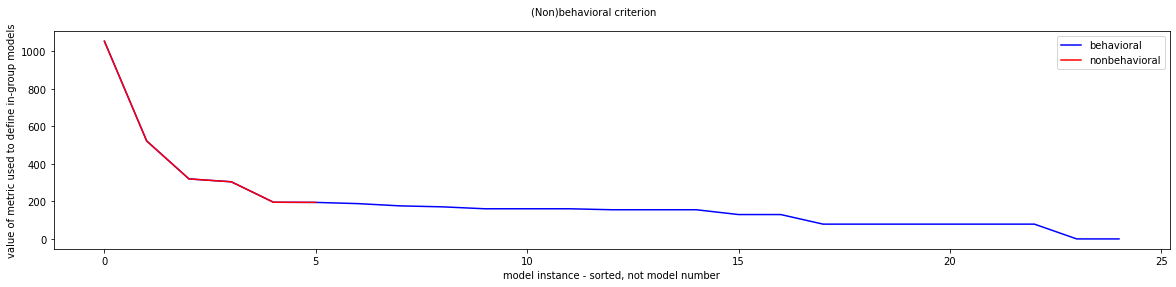

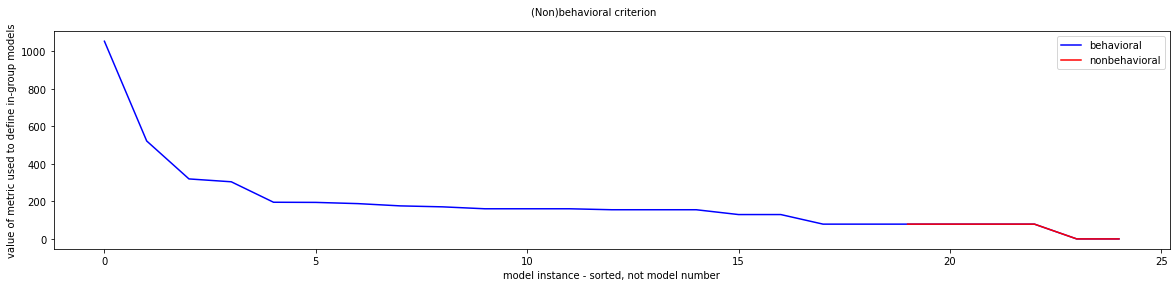

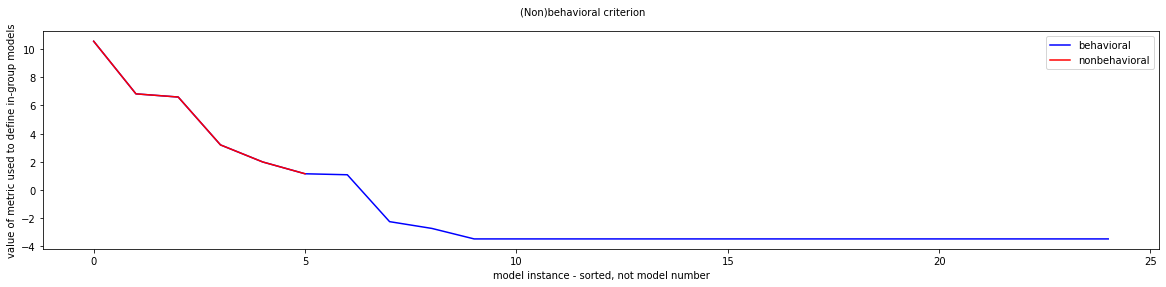

There were  1 models of concern.

Models of concern:
m002441330133423

Assessing prevalence of each parameter for models of concern and other models

                                              Ky    low Kz   Sy    Rm      ETv     ETr   Kstr

Models of concern average ---------------- [0. 0. 3. 4. 2. 2. 4.]
Models of concern standard deviation ----- [0. 0. 0. 0. 0. 0. 0.]

Other model average ---------------------- [1.889 1.278 2.    2.056 2.    2.333 2.833]
Other model standard deviation ----------- [1.559 0.989 1.452 1.223 1.414 1.527 1.013]



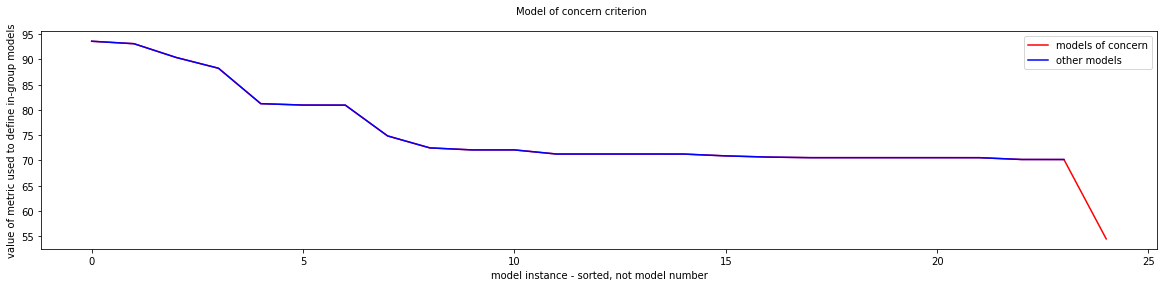

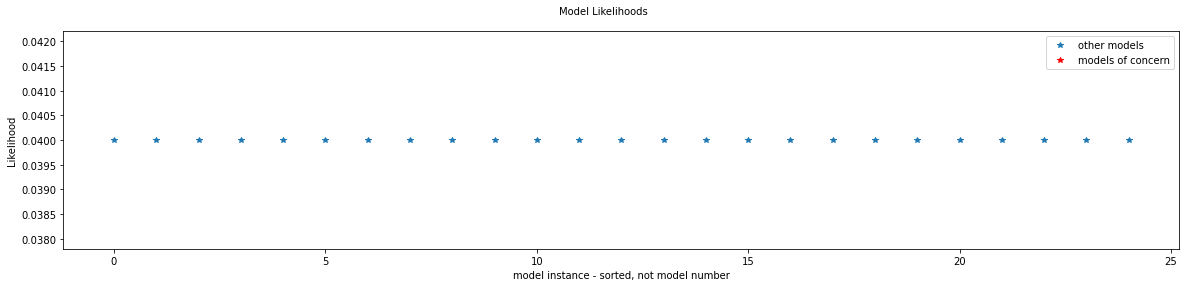

Models with highest likelihoods

m002441330034224  L = 0.0 other model
m002441330103303  L = 0.0 other model
m002441330133143  L = 0.0 other model
m002441330133423  L = 0.0 other model
m002441330143000  L = 0.0 other model
m002441331133233  L = 0.0 other model
m002441331133321  L = nan other model
m002441331313402  L = nan other model
m002441332101423  L = nan other model
m002441332133243  L = nan other model

The total likelihood of the models of concern is  nan


In [89]:
print('The final ensemble includes ',np.shape(runnumbers)[0],' models')
print()

if np.shape(nonbehavioral_ids)[0]>0:
    print('There were ', np.shape(nonbehavioral_ids)[0],'non-behavioral models.')
    print()
    print('Non-behavioral models:')
    for i in np.arange(np.shape(nonbehavioral_ids)[0]):
        print(nonbehavioral_ids[i])
    print()
    print('There were ', np.shape(Lcut_ids)[0],'low likelihood models.')
    if np.shape(Lcut_ids)[0]>0 and lowLecho==True:
        print()
        print('Low-likelihood models:')
        for i in Lcut_ids:
            print(runnumbers[i])
    print()
print('Assessing prevalence of each parameter for behavioral and non-behavioral models')
print()
print('                                       Ky    low Kz   Sy    Rm      ETv     ETr   Kstr')
print()
print('Behavioral average ----------------',np.floor(b_meanid*1000)/1000)
print('Behavioral deviation --------------',np.floor(b_varid*1000)/1000)
print()
plottitle='(Non)behavioral criterion'
if np.shape(nonbehavioral_ids)[0]>0:
    print('Non-behavioral average ------------',np.floor(nonb_meanid*1000)/1000)
    print('Non-behavioral standard deviation -',np.floor(nonb_varid*1000)/1000)
    print()
    for ij in np.arange(np.shape(holdplotx)[0]):
        if holdplottype[ij]==0:
            f0,ax1 = plt.subplots(1,1,figsize=(20,4))                                             # create & return figure & axes at position (row, col) of size 20x12 inches
            tempplotx=holdplotx[ij][:]
            tempploty=holdploty[ij][:]
            c = ax1.plot(tempplotx,tempploty,color="blue",label='behavioral')     
            tempplotx=tempplotx[holdleftlimit[ij]:holdrightlimit[ij]]
            tempploty=tempploty[holdleftlimit[ij]:holdrightlimit[ij]]
            c = ax1.plot(tempplotx,tempploty,color="red",label='nonbehavioral')     
            ax1.set_xlabel('model instance - sorted, not model number')
            ax1.set_ylabel('value of metric used to define in-group models')
            ax1.legend()
            plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
            plt.show(f0)   
        else:
            skipprint=1

else:
    print('All models are behavioral')

if run_sections>0:

    if np.shape(moc_ids)[0]>0:
        print('There were ', np.shape(moc_ids)[0],'models of concern.')
        print()
        print('Models of concern:')
        for i in np.arange(np.shape(moc_ids)[0]):
            print(moc_ids[i])
        print()

    if define_mocs == True:
        print('Assessing prevalence of each parameter for models of concern and other models')
        print()
        print('                                              Ky    low Kz   Sy    Rm      ETv     ETr   Kstr')
        print()
        print('Models of concern average ----------------',np.floor(moc_meanid*1000)/1000)
        print('Models of concern standard deviation -----',np.floor(moc_varid*1000)/1000)
        print()
        plottitle='Model of concern criterion'
    if np.shape(moc_ids)[0]>0:
        print('Other model average ----------------------',np.floor(other_meanid*1000)/1000)
        print('Other model standard deviation -----------',np.floor(other_varid*1000)/1000)
        print()
        moccounter=-1
        for ij in np.arange(np.shape(holdplotx)[0]):
            if holdplottype[ij]==1:
                moccounter=moccounter+1
                f1,ax1 = plt.subplots(1,1,figsize=(20,4))                                             # create & return figure & axes at position (row, col) of size 20x12 inches
                tempplotx=holdplotx[ij][:]
                tempploty=holdploty[ij][:]
                c = ax1.plot(tempplotx,tempploty,color="red",label='models of concern')     
                tempplotx=tempplotx[int(holdleftlimit[ij]):int(holdrightlimit[ij])]
                tempploty=tempploty[int(holdleftlimit[ij]):int(holdrightlimit[ij])]
                c = ax1.plot(tempplotx,tempploty,color="blue",label='other models')     
                ax1.set_xlabel('model instance - sorted, not model number')
                ax1.set_ylabel('value of metric used to define in-group models')
                plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
                ax1.legend()
                plt.show(f1)     
            else:
                skipprint=1
    else:
        print('There are no models of concern')

    plottitle='Model Likelihoods'
    f2,ax1 = plt.subplots(1,1,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    xplot=np.arange(len(runnumbers))                                                                  # plot sorted streamflows against number of runs
    c = ax1.plot(xplot,sorted_L,'*',label='other models')   
    tempvar=np.argsort(-L)
    xplot=np.zeros(np.shape(moc_ids_counter)[0])
    yplot=np.zeros(np.shape(moc_ids_counter)[0])
    count=-1
    Lsum_moc=0
    for i in np.arange(np.shape(tempvar)[0]):  
        if np.shape(np.intersect1d(tempvar[i],moc_ids_counter))[0]>0:
            count=count+1
            xplot[count]=(i)
            yplot[count]=(L[tempvar[i]])
            Lsum_moc=Lsum_moc+L[tempvar[i]]                                                           # keep track of total L in MOCs
    c = ax1.plot(xplot,yplot,'*',color="Red",label='models of concern')   
    ax1.set_xlabel('model instance - sorted, not model number')
    ax1.set_ylabel('Likelihood')
    plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
    ax1.legend()
    plt.show(f2)     

    print('Models with highest likelihoods')
    print()
    bestmodels=np.argsort(-L)
    numbest=np.shape(bestmodels)[0]
    if numbest>10:
        numbest=10

    for i in range(numbest):
        if runnumbers[bestmodels[i]] in moc_ids:
            print(runnumbers[i],' L =', np.floor(L[bestmodels[i]]*1000)/1000, 'model of concern')
        else:
            print(runnumbers[i],' L =', np.floor(L[bestmodels[i]]*1000)/1000, 'other model')

    print()
    print('The total likelihood of the models of concern is ',np.floor(Lsum_moc*1000)/1000)

    del plottitle                                                                                     # clear temporary variables
    del tempplotx
    del tempploty
    del skipprint
#     del bestmodels
    del numbest
    del count
    del xplot
    del yplot
    del tempvar

In [90]:
print(L)
print(runnumbers)
print(nonb_meanid)

[ 0.  0.  0. nan  0. nan nan nan nan nan nan nan nan nan  0.  0. nan nan
 nan nan nan nan nan nan nan]
['m002441330034224', 'm002441330103303', 'm002441330133143', 'm002441330133423', 'm002441330143000', 'm002441331133233', 'm002441331133321', 'm002441331313402', 'm002441332101423', 'm002441332133243', 'm002441332331133', 'm002441332400314', 'm002441333103133', 'm002441334041043', 'm002441334101144', 'm002441334111444', 'm002441334120103', 'm002441334131042', 'm002441334131113', 'm002441334133143', 'm002441334133443', 'm002441334212101', 'm002441334300142', 'm002441334433402', 'm002441334443443']
[0.167 0.833 2.667 3.167 2.    1.833 2.667]


In [91]:
print(sorted_L[0:10])

[0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]


## Head-related contour plots

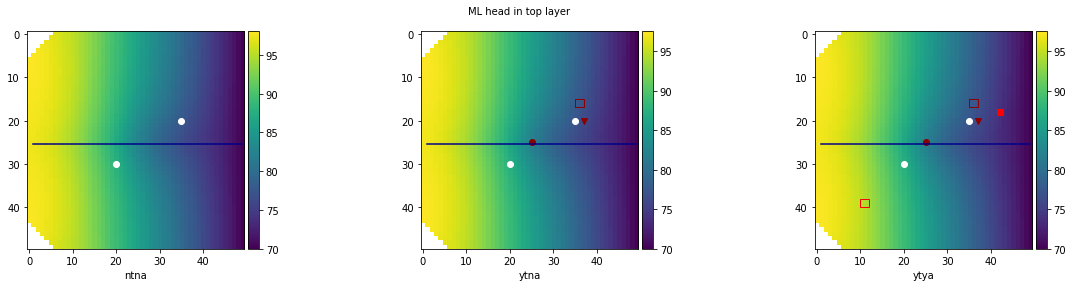

ValueError: arange: cannot compute length

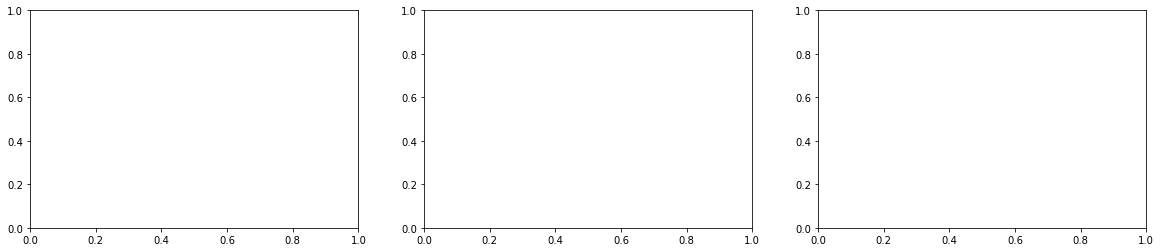

In [92]:
def make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle):                  # function to create contour plots                                                      # use this to generate contour plots with streams, wells, return locations, infiltration areas and add x axis titles
    extent = (0, ncol, 0, nrow)                                                                   # sets plot boundaries (x0,x1,y0,y1)
    for t in np.arange(3):                                                                        # one plot for each steady state condition
        if t==0:
            h=data_ntna
        elif t==1:
            h=data_ytna
        else:
            h=data_ytya
        h[h==0]=np.nan                                                                            # remove false zero values to improve color fill limits
        levels = np.arange(np.nanmin(h),np.nanmax(h),(np.nanmax(h)-np.nanmin(h))/100)             # creates an array of values used to determine which contour values to draw
        ax1[t].invert_yaxis()                                                                     # reverse y axis direction so that row 0 is at the top

#         c = ax1[t].contour(h, extent=extent, levels=levels, colors='SteelBlue')                 # plot contours for all rows & columns in layer 1
        im = ax1[t].imshow(h,cmap=cm.viridis)                                                     # plot head as a colormap
        divider = make_axes_locatable(ax1[t])                                                     # set up colorbar location (need to import make_axes_locatable - see top cell)
        cax = divider.append_axes("right", size="5%", pad=0.05)                                   # place colorbar axes on right side of each subplot
        plt.colorbar(mappable=im, cax = cax)                                                      # draw colorbar
        ax1[t].plot(str_cols, str_rows+.5, c='DarkBlue', label='stream')                                          # plot stream location (col = x, row = y)
        for ij in np.arange(np.shape(data_basis_sequence)[0]):
            ax1[t].scatter(data_column_sequence[ij], data_row_sequence[ij], c='White', label='? data basis sequence')
        if t>0:
            ax1[t].scatter(well1[2], well1[1], c='DarkRed', marker='v', label='town well')                                       # plot town well location (col = x, row = y)
            ax1[t].scatter(return_loc,25, c='DarkRed', marker='o', label='town return location')                                            # plots town return location (col = x, row = y)
            townrect = patches.Rectangle((rNWc[2],rNWc[1]),2,2,linewidth=1,
                 edgecolor='DarkRed',facecolor='none', label='town location')
            ax1[t].add_patch(townrect)
        if t>1:
            ax1[t].scatter(well2[2], well2[1], c='Red', marker='s', label='irrigation well')                                           # plot irrigation well location (col = x, row = y)
            farmrect = patches.Rectangle((fNWc[1],fNWc[0]),2,2,linewidth=1,
                 edgecolor='Red',facecolor='none', label='farm irrigation area')
            ax1[t].add_patch(farmrect)                                                            # plot farm irrigation area
        if t==0:                                       
            ax1[t].set_xlabel('ntna')                                                             # label x axis to identify steady state condition
        elif t==1:      
            ax1[t].set_xlabel('ytna')
            plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
        else:
            ax1[t].set_xlabel('ytya') 
        # plt.legend()

if run_sections>-1:
    print()
    plottitle='ML head in top layer'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=headML_ss_ntna
    data_ntna[np.isnan(data_ntna)]=-1
    data_ytna=headML_ss_ytna
    data_ytya=headML_ss_ytya
    f3aa,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    # plt.legend(f3aa) 
    plt.show(f3aa)  

    print()
    plottitle='Mean head in top layer over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=headmean_ss_ntna
    data_ntna[np.isnan(data_ntna)]=-1
    data_ytna=headmean_ss_ytna
    data_ytya=headmean_ss_ytya
    f3a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle) 
    plt.show(f3a)  

    plottitle='Standard deviation of head in top layer over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=headvar_ss_ntna
    data_ytna=headvar_ss_ntna
    data_ytya=headvar_ss_ntna
    f3b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f3b)     

    print()
    plottitle='Mean drawdown in top layer due to agriculture over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytya=ddmean
    f7a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f7a)     

    print()
    plottitle='Standard deviation of drawdown in top layer due to agriculture over all models'
    minval=0                                                                                          # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytya=ddvar
    f7b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f7b)     


if run_sections>0:
    if np.shape(moc_ids_counter)[0] > 0:
        print()
        plottitle='Mean head in top layer over models of concern'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=moc_headmean_ss_ntna
        data_ytna=moc_headmean_ss_ytna
        data_ytya=moc_headmean_ss_ytya
        f4a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f4a)     

        plottitle='Standard deviation of head in top layer over MOCs'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=moc_headvar_ss_ntna
        data_ytna=moc_headvar_ss_ntna
        data_ytya=moc_headvar_ss_ntna
        f4b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f4b)     

        print()
        plottitle='Mean head in top layer over other models'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=other_headmean_ss_ntna
        data_ytna=other_headmean_ss_ytna
        data_ytya=other_headmean_ss_ytya
        f5a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f5a)     

        plottitle='Standard deviation of head in top layer over other models'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=other_headvar_ss_ntna
        data_ytna=other_headvar_ss_ntna
        data_ytya=other_headvar_ss_ntna
        f5b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f5b)     

if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        print()
        plottitle='Absolute difference in mean head in top layer models of concern versus other models'
        minval=0.1                                                                                    # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=meandiff_ntna
        data_ytna=meandiff_ytna
        data_ytya=meandiff_ytya
        f6a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f6a)     

        print()
        plottitle='Sum of standard deviations in top layer models of concern and other models'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=sumvar_ntna
        data_ytna=sumvar_ytna
        data_ytya=sumvar_ytya
        f6b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f6b)     

        print()
        plottitle='Mean abs head difference, top layer, MOCs versus other models divided by sum of standard deviations rounded to 1 sig fig'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=di_std_ntna
        data_ytna=di_std_ytna
        data_ytya=di_std_ytya
        f6c,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,np.round(10*data_ntna)/10,np.round(10*data_ytna)/10,
             np.round(10*data_ytya)/10,minval,plottitle)
        plt.show(f6c)

        print()
        plottitle='Summed likelihood of models with overlapping head values between MOCs and other models - smaller is better'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=overlap_ntna_head
        data_ytna=overlap_ytna_head
        data_ytya=overlap_ytya_head
        f6d,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
        plt.show(f6d)     

        print()
        plottitle='Mean abs head difference, top layer, MOCs versus other models multiplied by (1-overlap) - rounded to 1 sig fig'
        minval=0                                                                                      # minimum allowable value ... only used for difference plot to identify measurable differences
        data_ntna=di_overlap_ntna
        data_ytna=di_overlap_ytna
        data_ytya=di_overlap_ytya
        f6e,ax1 = plt.subplots(1,3,figsize=(20,4))                                                     # create & return figure & axes at position (row, col) of size 20x12 inches
        make_contour_plot(ncol,nrow,np.round(10*data_ntna)/10,np.round(10*data_ytna)/10,
             np.round(10*data_ytya)/10,minval,plottitle)
        plt.show(f6e)     

        #Export files needed for multi-stakeholder comparisons:
        #To import, use np.load()
        comparison_directory()               #change directory to current stakeholder and stage
        np.save(prefix + 'di_std', di_std_ytna)
        output_directory()

    del minval
    del data_ntna
    del data_ytna
    del data_ytya
    del plottitle

## Particle-related contour plots

In [93]:
if run_sections>2:
    plottitle='Fraction of models predicting capture of recharge in town cell at each cell in top layer over all models'
    minval=0                                                                                           # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=w1capgrid[1][:][:]
    data_ytya=w1capgrid[2][:][:]
    
    f8a,ax1 = plt.subplots(1,3,figsize=(20,4))                                                          # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f8a)

    print()
    plottitle='Fraction of models predicting capture or recharge in ag cell at each cell in top layer over all models'
    minval=0                                                                                           # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytna=np.random.rand(np.shape(ddmean)[0],np.shape(ddmean)[0])*1e-10
    data_ytya=w2capgrid[2][:][:]
    f8b,ax1 = plt.subplots(1,3,figsize=(20,4))                                                          # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f8b)

    print()
    plottitle='Fraction of models predicting capture or recharge in stream at each cell in top layer over all models'
    minval=0                                                                                           # minimum allowable value ... only used for difference plot to identify measurable differences
    data_ntna=strcapgrid[0][:][:]
    data_ytna=strcapgrid[1][:][:]
    data_ytya=strcapgrid[2][:][:]
    f8c,ax1 = plt.subplots(1,3,figsize=(20,4))                                                          # create & return figure & axes at position (row, col) of size 20x12 inches
    make_contour_plot(ncol,nrow,data_ntna,data_ytna,data_ytya,minval,plottitle)
    plt.show(f8c)

    del minval                                                                                         # clear temporary variables
    del plottitle
    # del data_ntnagt
    del data_ytna
    del data_ytya

## Transect plots along stream

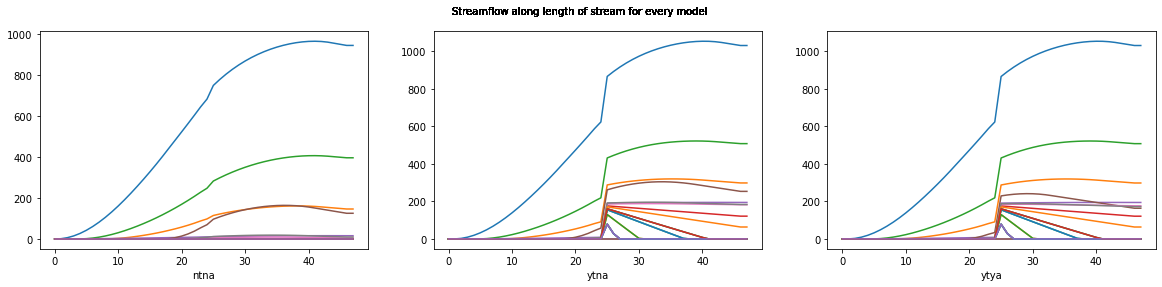

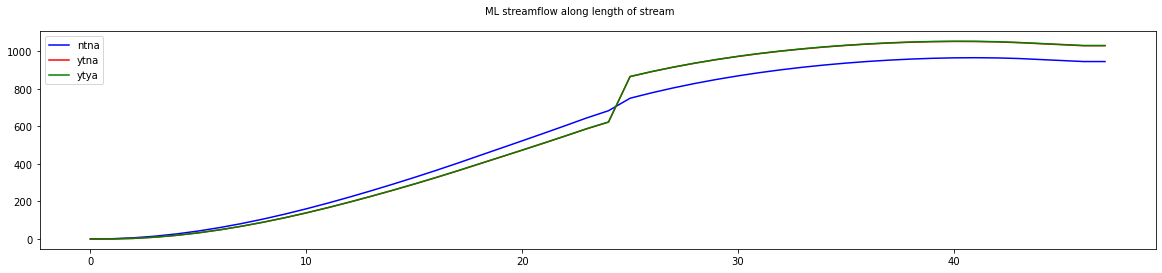

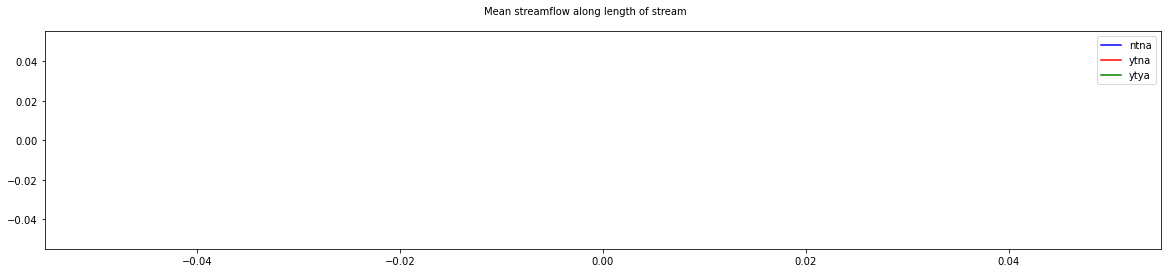

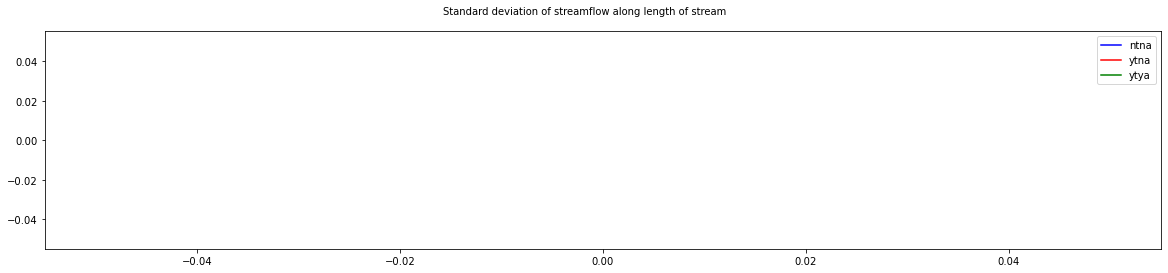

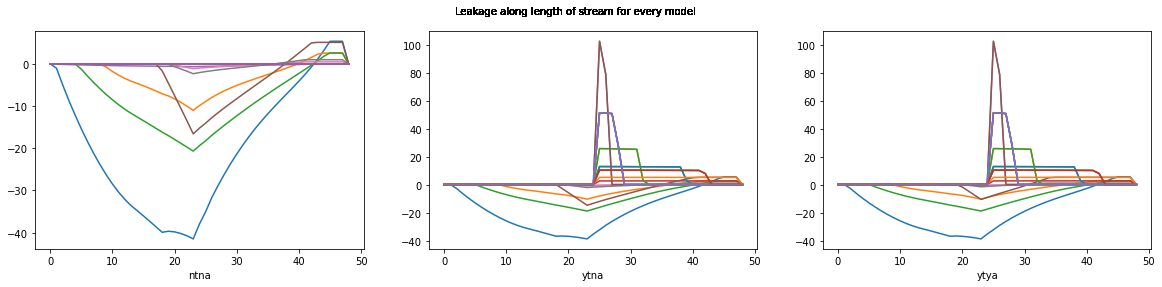

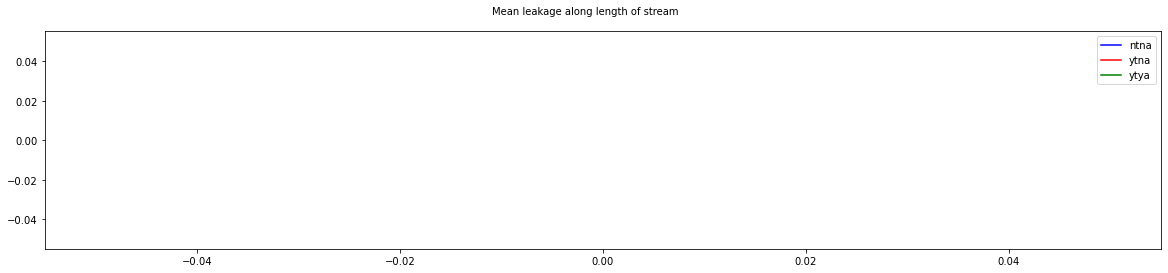

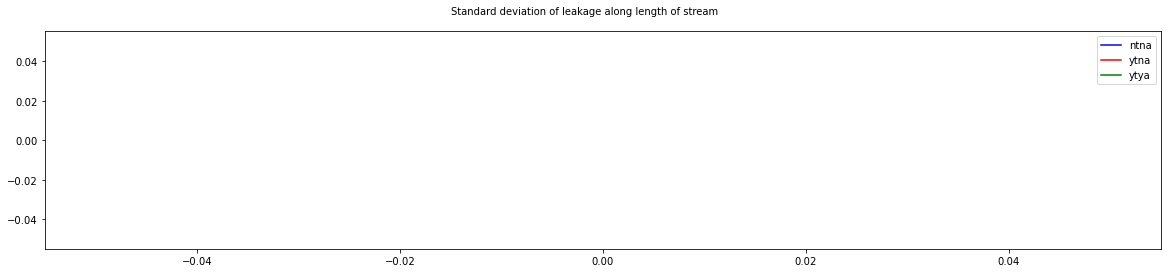

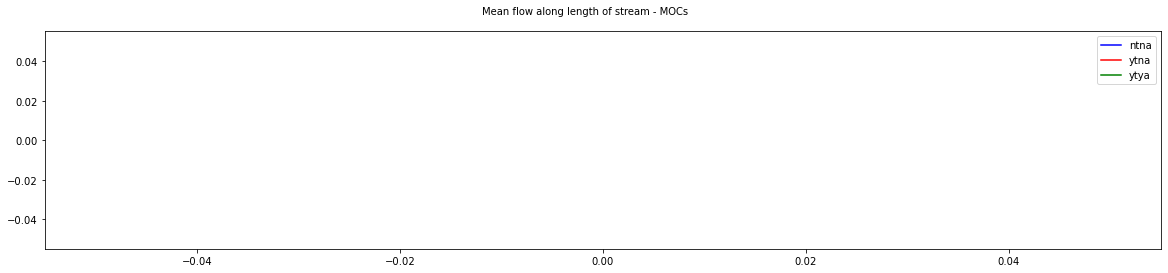

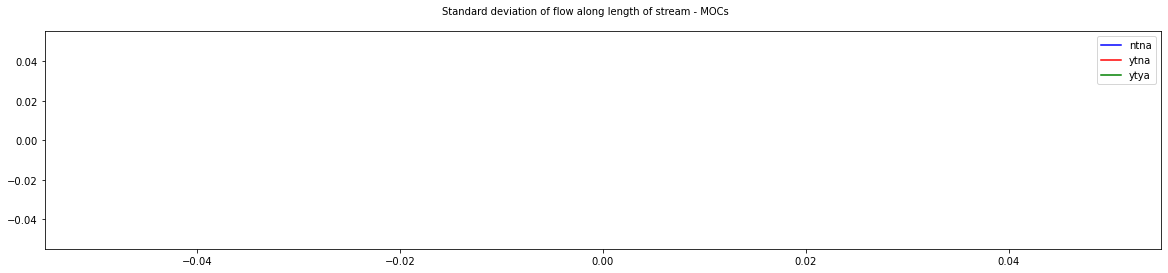

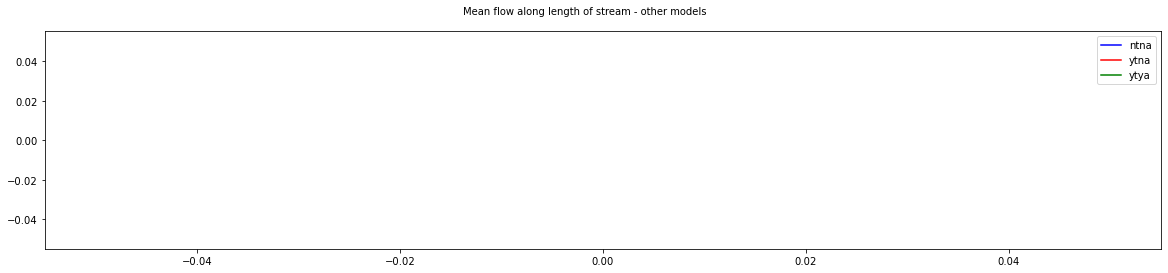

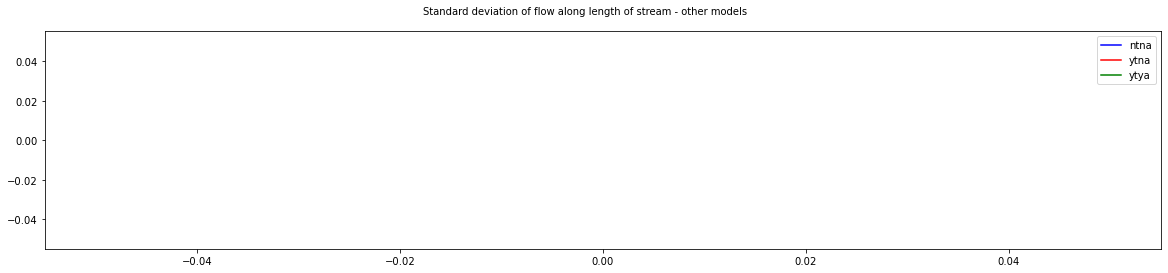

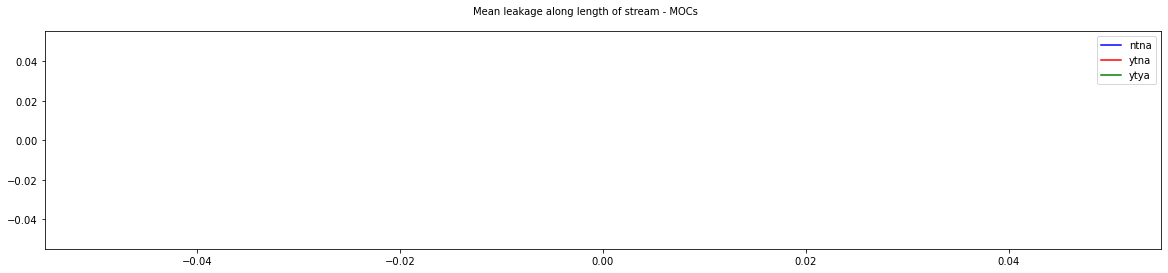

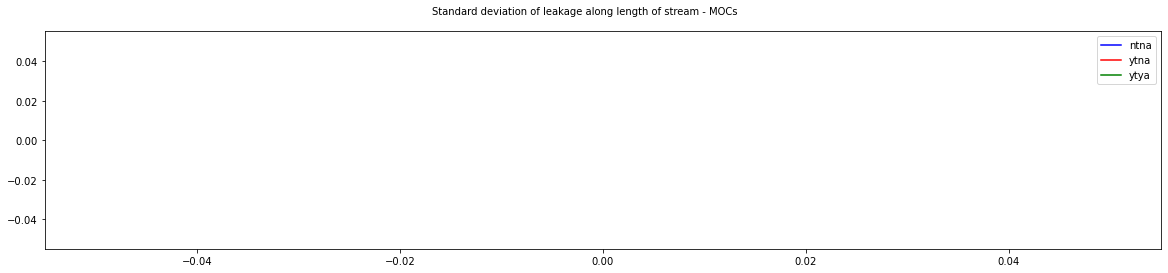

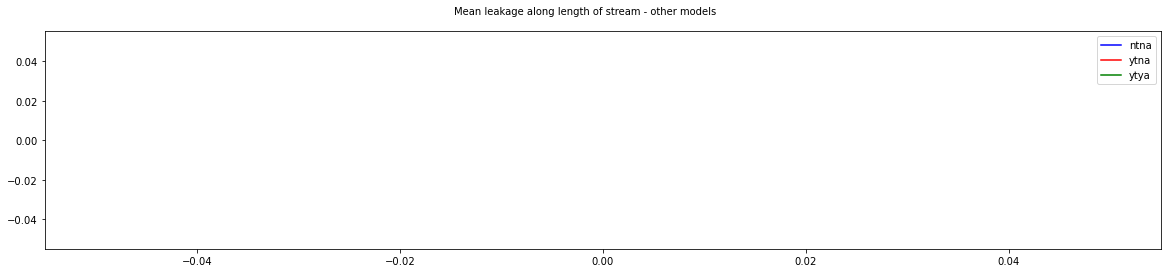

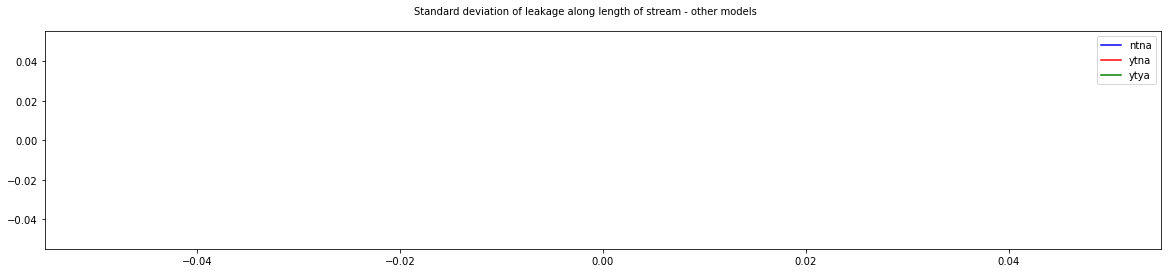

In [94]:
def make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle):
    matrixdim=data_ntna.ndim
    if matrixdim==1:                                                                              # single trace
        numloops=1
        xplot=np.shape(data_ntna)[0]
    else:                                                                                         # trace for each model run
        numloops=np.shape(data_ntna)[0]
        xplot=np.shape(data_ntna)[1]
    for t in np.arange(3):                                                                        # one plot for each steady state condition
        for i in np.arange(numloops):
            if matrixdim==1:
                if t==0:                                                                          # label x axis to identify steady state condition
                    c = ax1.plot(np.arange(xplot),data_ntna,color='blue',label='ntna')            # plot contours for all rows & columns in layer 1
                elif t==1:
                    c = ax1.plot(np.arange(xplot),data_ytna,color='red',label='ytna')             # plot contours for all rows & columns in layer 1
                    plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
                else:
                    c = ax1.plot(np.arange(xplot),data_ytya,color='green',label='ytya')           # plot contours for all rows & columns in layer 1
                    ax1.legend()
            else:
                if t==0:                                                                          # label x axis to identify steady state condition
                    c = ax1[t].plot(np.arange(xplot),data_ntna[i])                                # plot contours for all rows & columns in layer 1
                    ax1[t].set_xlabel('ntna')
                elif t==1:
                    c = ax1[t].plot(np.arange(xplot),data_ytna[i])                                # plot contours for all rows & columns in layer 1
                    ax1[t].set_xlabel('ytna')
                    plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
                else:
                    c = ax1[t].plot(np.arange(xplot),data_ytya[i])                                # plot contours for all rows & columns in layer 1
                    ax1[t].set_xlabel('ytya')                    
    
    
if run_sections>-1:
    plottitle='Streamflow along length of stream for every model'
    data_ntna=allflows_ss_ntna
    data_ytna=allflows_ss_ytna
    data_ytya=allflows_ss_ytya
    f10a,ax1 = plt.subplots(1,3,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10a)                                                      

    plottitle='ML streamflow along length of stream'
    data_ntna=flowML_ss_ntna
    data_ytna=flowML_ss_ytna
    data_ytya=flowML_ss_ytya
    f10aa,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10aa)                                                      

    plottitle='Mean streamflow along length of stream'
    data_ntna=flowmean_ss_ntna
    data_ytna=flowmean_ss_ytna
    data_ytya=flowmean_ss_ytya
    f10b,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10b)                                                      

    plottitle='Standard deviation of streamflow along length of stream'
    data_ntna=flowvar_ss_ntna
    data_ytna=flowvar_ss_ytna
    data_ytya=flowvar_ss_ytya
    f10c,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f10c)                                                      

    plottitle='Leakage along length of stream for every model'
    data_ntna=allleaks_ss_ntna
    data_ytna=allleaks_ss_ytna
    data_ytya=allleaks_ss_ytya
    f11a,ax1 = plt.subplots(1,3,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f11a)                                                      

    plottitle='Mean leakage along length of stream'
    data_ntna=leakmean_ss_ntna
    data_ytna=leakmean_ss_ytna
    data_ytya=leakmean_ss_ytya
    f11b,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f11b)                                                      

    plottitle='Standard deviation of leakage along length of stream'
    data_ntna=leakvar_ss_ntna
    data_ytna=leakvar_ss_ytna
    data_ytya=leakvar_ss_ytya
    f11c,ax1 = plt.subplots(1,1,figsize=(20,4))           
    make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
    plt.show(f11c)                                                      

if run_sections>0:
    if np.shape(moc_ids_counter)[0] > 0:

        plottitle='Mean flow along length of stream - MOCs'
        data_ntna=moc_flowmean_ss_ntna
        data_ytna=moc_flowmean_ss_ytna
        data_ytya=moc_flowmean_ss_ytya
        f12a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12a)                                                      

        plottitle='Standard deviation of flow along length of stream - MOCs'
        data_ntna=moc_flowvar_ss_ntna
        data_ytna=moc_flowvar_ss_ytna
        data_ytya=moc_flowvar_ss_ytya
        f12b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12b)                                                      

        plottitle='Mean flow along length of stream - other models'
        data_ntna=other_flowmean_ss_ntna
        data_ytna=other_flowmean_ss_ytna
        data_ytya=other_flowmean_ss_ytya
        f12c,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12c)                                                      

        plottitle='Standard deviation of flow along length of stream - other models'
        data_ntna=other_flowvar_ss_ntna
        data_ytna=other_flowvar_ss_ytna
        data_ytya=other_flowvar_ss_ytya
        f12d,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f12d)                                                      

if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Difference in mean flow - MOCs vs other models'
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)
        f13a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13a)                                                      

        plottitle='Sum of standard deviations of flow - MOCs vs other models'
        data_ntna=np.abs(moc_flowvar_ss_ntna+other_flowvar_ss_ntna)
        data_ytna=np.abs(moc_flowvar_ss_ytna+other_flowvar_ss_ytna)
        data_ytya=np.abs(moc_flowvar_ss_ytya+other_flowvar_ss_ytya)
        f13b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13b)                                                      

        plottitle='Difference in mean flow divided by sum of st devs - MOCs vs other models'
        tempvar=np.abs(moc_flowvar_ss_ntna+other_flowvar_ss_ntna)
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)/tempvar
        tempvar=np.abs(moc_flowvar_ss_ytna+other_flowvar_ss_ytna)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)/tempvar
        tempvar=np.abs(moc_flowvar_ss_ytya+other_flowvar_ss_ytya)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)/tempvar
        f13c,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13c)                                                      

        plottitle='Degree of overlap of flow - MOCs vs other models'
        data_ntna=overlap_ntna_flow
        data_ytna=overlap_ytna_flow
        data_ytya=overlap_ytya_flow
        f13d,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13d)                                                      

        plottitle='Difference in mean flow times (1-overlap) - MOCs vs other models'
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)*(1-overlap_ntna_flow)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)*(1-overlap_ytna_flow)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)*(1-overlap_ytya_flow)
        f13e,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f13e)                                                      

if run_sections>0:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Mean leakage along length of stream - MOCs'
        data_ntna=moc_leakmean_ss_ntna
        data_ytna=moc_leakmean_ss_ytna
        data_ytya=moc_leakmean_ss_ytya
        f14a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14a)                                                      

        plottitle='Standard deviation of leakage along length of stream - MOCs'
        data_ntna=moc_leakvar_ss_ntna
        data_ytna=moc_leakvar_ss_ytna
        data_ytya=moc_leakvar_ss_ytya
        f14b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14b)                                                      

        plottitle='Mean leakage along length of stream - other models'
        data_ntna=other_leakmean_ss_ntna
        data_ytna=other_leakmean_ss_ytna
        data_ytya=other_leakmean_ss_ytya
        f14c,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14c)                                                      

        plottitle='Standard deviation of leakage along length of stream - other models'
        data_ntna=other_leakvar_ss_ntna
        data_ytna=other_leakvar_ss_ytna
        data_ytya=other_leakvar_ss_ytya
        f14d,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f14d)                                                      

if run_sections>1:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Difference in mean leakage - MOCs vs other models'
        data_ntna=np.abs(moc_leakmean_ss_ntna-other_leakmean_ss_ntna)
        data_ytna=np.abs(moc_leakmean_ss_ytna-other_leakmean_ss_ytna)
        data_ytya=np.abs(moc_leakmean_ss_ytya-other_leakmean_ss_ytya)
        f15a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f15a)                                                      

        plottitle='Sum of standard deviations of leakage - MOCs vs other models'
        data_ntna=np.abs(moc_leakvar_ss_ntna+other_leakvar_ss_ntna)
        data_ytna=np.abs(moc_leakvar_ss_ytna+other_leakvar_ss_ytna)
        data_ytya=np.abs(moc_leakvar_ss_ytya+other_leakvar_ss_ytya)
        f15b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f15b)                                                      

# THIS ISN'T WORKING RIGHT NOW ... NOT SURE WHY
#     plottitle='Difference in mean leakage divided by sum of st devs - MOCs vs other models'
#     temvpar=np.abs(moc_leakvar_ss_ntna+other_leakvar_ss_ntna)
#     data_ntna=np.abs(moc_leakmean_ss_ntna-other_leakmean_ss_ntna)/tempvar
#     temvpar=np.abs(moc_leakvar_ss_ytna+other_leakvar_ss_ytna)
#     data_ytna=np.abs(moc_leakmean_ss_ytna-other_leakmean_ss_ytna)/tempvar
#     temvpar=np.abs(moc_leakvar_ss_ytya+other_leakvar_ss_ytya)
#     data_ytya=np.abs(moc_leakmean_ss_ytya-other_leakmean_ss_ytya)/tempvar
#     f15,ax1 = plt.subplots(1,1,figsize=(20,4))           
#     make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
#     plt.show(f15)                                                      

if run_sections>2:
    if np.shape(moc_ids_counter)[0] > 0:
        plottitle='Degree of overlap of leakage - MOCs vs other models'
        data_ntna=overlap_ntna_flow
        data_ytna=overlap_ytna_flow
        data_ytya=overlap_ytya_flow
        f9a,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f9a)                                                      

        plottitle='Difference in mean leakage times (1-overlap) - MOCs vs other models'
        data_ntna=np.abs(moc_flowmean_ss_ntna-other_flowmean_ss_ntna)*(1-overlap_ntna_flow)
        data_ytna=np.abs(moc_flowmean_ss_ytna-other_flowmean_ss_ytna)*(1-overlap_ytna_flow)
        data_ytya=np.abs(moc_flowmean_ss_ytya-other_flowmean_ss_ytya)*(1-overlap_ytya_flow)
        f9b,ax1 = plt.subplots(1,1,figsize=(20,4))           
        make_profile_plot(data_ntna,data_ytna,data_ytya,plottitle)
        plt.show(f9b)                                                      

if run_sections>2:
    del tempvar

## Histograms at selected locations

Locations of observation points, wells, and return flow


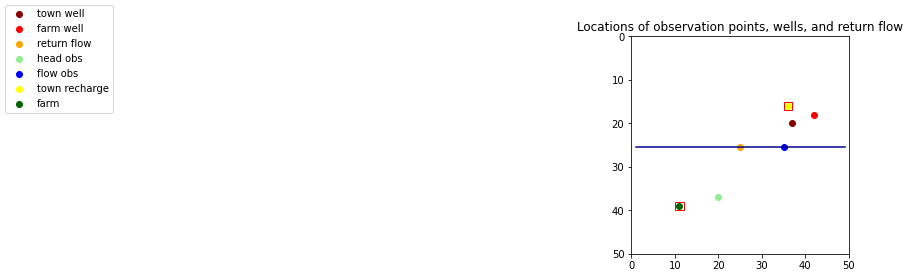

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


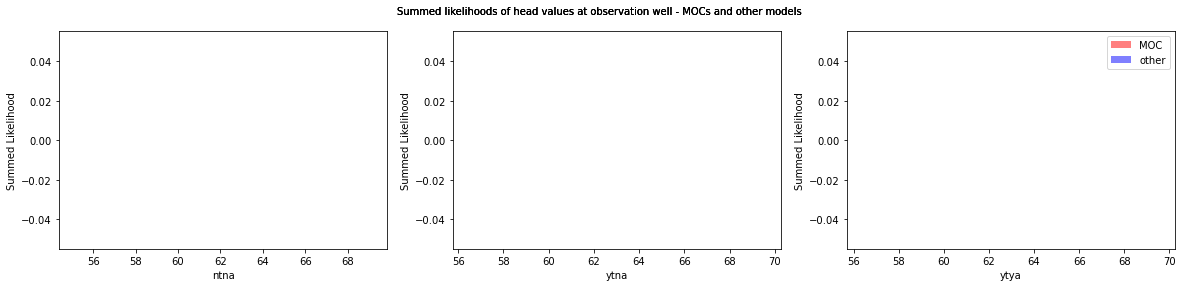

In [95]:
print('Locations of observation points, wells, and return flow')
f16,ax1 = plt.subplots(1,1,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
extent = (0, ncol, 0, nrow)                                                                        # sets plot boundaries (x0,x1,y0,y1)
ax1.invert_yaxis()                                                                                 # reverses y axis direction so that row 0 is at the top
ax1.set_aspect(aspect='equal')
w1=ax1.scatter(well1[2], well1[1], c='DarkRed')                                                    # plot town well location (col = x, row = y)
w2=ax1.scatter(well2[2], well2[1], c='Red')                                                        # plot irrigation well location (col = x, row = y)
hobs=ax1.scatter(displaycolumn, displayrow, c='LightGreen')                                        # plot selected head location 
strobs=ax1.scatter(strdisplaycolumn, 25.5, c='Blue')                                               # plot selected stream flow location 
townret=ax1.scatter(return_loc, 25.5, c='Orange')                                                  # plot town return to stream 
ax1.plot(str_cols, str_rows+.5, c='DarkBlue')                                                      # plot stream location (col = x, row = y)
townrect = patches.Rectangle((rNWc[2],rNWc[1]),2,2,linewidth=1,edgecolor='Red',facecolor='none')
townmidx = rNWc[2]+1
townmidy = rNWc[1]+1
town_rech=ax1.scatter(townmidx, townmidy, c='Yellow')                                                                # plot town well location (col = x, row = y)
ax1.add_patch(townrect)                                                                            # plots town irrigation area
farmrect = patches.Rectangle((fNWc[1],fNWc[0]),2,2,linewidth=1,edgecolor='Red',facecolor='none')
agmidx = fNWc[1]+1
agmidy = fNWc[0]+1
ag_rech=ax1.scatter(agmidx, agmidy, c='DarkGreen')                                                 # plot town well location (col = x, row = y)
ax1.add_patch(farmrect)                                                                            # plots farm irrigation area
f16.legend([w1,w2,townret,hobs,strobs,town_rech,ag_rech],['town well','farm well','return flow',
     'head obs','flow obs','town recharge','farm'],loc=2)                                          # add legend center right
plt.title('Locations of observation points, wells, and return flow')
ax1.set_xlim(0,50)
ax1.set_ylim(50,0)
plt.show(f16)                                                                                      # display plot (not always necessary)

def plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,displaycolumn,plottitle):
    matrixdim=data_ntna.ndim
    for j in np.arange(3):                                                                         # create plot for each steady state condition
        tempvals=[]
        tempws=[]
        for i in np.arange(np.shape(data_ntna)[0]):
            if matrixdim==2:
                if j==0:
                    addval=data_ntna[i][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displaycolumn]
                    addweight=L[i]
            else:
                if j==0:
                    addval=data_ntna[i][displayrow][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displayrow][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displayrow][displaycolumn]
                    addweight=L[i]
            tempvals.append(addval)
            tempws.append(addweight)
        c = ax1[j].hist(tempvals,weights=tempws)                                                  # plots histogram of head in layer 1 across all models
        if j==0:                                                                                  # label x axis to identify steady state condition
            ax1[j].set_xlabel('ntna')
        elif j==1:
            ax1[j].set_xlabel('ytna')
            plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
        else:
            ax1[j].set_xlabel('ytya')
        ax1[j].set_ylabel('Summed Likelihood')

def plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
     displayrow,displaycolumn,plottitle):
    matrixdim=data_ntna.ndim
    
    for j in np.arange(3):    
        tempvals=[]
        tempws=[]
        for i in moc_ids_counter:                                                                 # plot drawdown due to ag at steady state
            if matrixdim==2:
                if j==0:
                    addval=data_ntna[i][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displaycolumn]
                    addweight=L[i]
            else:
                if j==0:
                    addval=data_ntna[i][displayrow][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displayrow][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displayrow][displaycolumn]
                    addweight=L[i]
            if addval>0:
                tempvals.append(addval)
                tempws.append(addweight)
        tempvals2=[]
        tempws2=[]
        for i in other_ids_counter:                                                               # plot drawdown due to ag at steady state
            if matrixdim==2:
                if j==0:
                    addval=data_ntna[i][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displaycolumn]
                    addweight=L[i]
            else:
                if j==0:
                    addval=data_ntna[i][displayrow][displaycolumn]
                    addweight=L[i]
                elif j==1:
                    addval=data_ytna[i][displayrow][displaycolumn]
                    addweight=L[i]
                else:
                    addval=data_ytya[i][displayrow][displaycolumn]
                    addweight=L[i]
            if addval>0:
                tempvals2.append(addval)
                tempws2.append(addweight)

        minval=min(np.min(tempvals),np.min(tempvals2))
        maxval=max(np.max(tempvals),np.max(tempvals2))        
        bins=minval+np.arange(20)*(maxval-minval)/20

        c = ax1[j].hist(tempvals,weights=tempws,bins=bins,alpha=0.5,color='red',label='MOC')                # plot contours for all rows & columns in layer 1
        c = ax1[j].hist(tempvals2,weights=tempws2,bins=bins,alpha=0.5,color='blue',label='other')             # plots contours for all rows & columns in layer 1
        if j==0:
            ax1[j].set_xlabel('ntna')
        elif j==1:
            ax1[j].set_xlabel('ytna')
        else:
            ax1[j].set_xlabel('ytya')        
        ax1[j].set_ylabel('Summed Likelihood')
        plt.legend(loc='upper right')
        plt.figtext(0.5, 0.95, plottitle, ha='center', va='center')
        

if run_sections>0:
    plottitle='Summed likelihoods of head values at observation well - MOCs and other models'
    data_ntna=allheads_ss_ntna
    data_ytna=allheads_ss_ytna
    data_ytya=allheads_ss_ytya
    f17,ax1 = plt.subplots(1,3,figsize=(20,4))                                                         # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
         displayrow,displaycolumn,plottitle)
    plt.show(f17)

#     plottitle='Summed likelihoods of drawdown due to ag at observation point - MOCs and other models'
#     data_ntna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
#          np.shape(allheads_ss_ytna)[2])*0
#     data_ytna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
#          np.shape(allheads_ss_ytna)[2])*0
#     data_ytya=allheads_ss_ytna-allheads_ss_ytya
#     f18,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
#     plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
#          displayrow,displaycolumn,plottitle)
#     plt.show(f18)                                                                                                                 # display plot (not always necessary)

#     plottitle='Summed likelihoods of flow values at observation cell - MOCs and other models'
#     data_ntna=allflows_ss_ntna
#     data_ytna=allflows_ss_ytna
#     data_ytya=allflows_ss_ytya
#     f19,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
#     plot_double_histograms(data_ntna,data_ytna,data_ytya,moc_ids_counter,other_ids_counter,
#          displayrow,strdisplaycolumn,plottitle)
#     plt.show(f19)                                                                                                                 # display plot (not always necessary)

#     if 'discindex_overlap' in locals():
#         plottitle='Normalized discriminatory index'
#         f20,ax1 = plt.subplots(1,1,figsize=(20,4))                                                    # create & return figure & axes at position (row, col) of size 20x12 inches
#         data_ytna=-1*np.sort(-discindex_overlap)
#         data_ytna[np.isnan(data_ytna)]=0
#         data_ytna=np.reshape(data_ytna, np.shape(data_ytna)[0]*np.shape(data_ytna)[1])
#         data_ytna=-np.sort(-data_ytna)
#         data_ytna=data_ytna/data_ytna[0]
#         c = ax1.plot(np.arange(np.shape(data_ytna)[0]),data_ytna,color="blue",label='overlap') 
#         data_ytna=-1*np.sort(-discindex_std)
#         data_ytna[np.isnan(data_ytna)]=0
#         data_ytna=np.reshape(data_ytna, np.shape(data_ytna)[0]*np.shape(data_ytna)[1])
#         data_ytna=-np.sort(-data_ytna)
#         data_ytna=data_ytna/data_ytna[0]
#         c = ax1.plot(np.arange(np.shape(data_ytna)[0]),data_ytna,color="red",label='st-dev') 
#         ax1.set_xlabel('sorted possible measurement locations')
#         ax1.set_ylabel('normalized discriminatory index')
#         plt.legend()
#         plt.show(f20)

elif run_sections>-1 and len(runnumbers)>1:
    plottitle='Summed likelihoods of head values at observation well'
    data_ntna=allheads_ss_ntna
    data_ytna=allheads_ss_ytna
    data_ytya=allheads_ss_ytya
    f17,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,displaycolumn,plottitle)
    plt.show(f17)                                                                                     # display plot (not always necessary)plt.show(f9)                                                         # display plot (not always necessary)

    plottitle='Summed likelihoods of drawdown due to ag  at observation well'
    data_ntna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
         np.shape(allheads_ss_ytna)[2])*0
    data_ytna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
         np.shape(allheads_ss_ytna)[2])*0
    data_ytya=allheads_ss_ytna-allheads_ss_ytya
    f18,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,displaycolumn,plottitle)
    plt.show(f18)                                                                                     # display plot (not always necessary)plt.show(f9)                                                         # display plot (not always necessary)

    plottitle='Summed likelihoods of flow values at observation cell'
    data_ntna=allflows_ss_ntna
    data_ytna=allflows_ss_ytna
    data_ytya=allflows_ss_ytya
    f19,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
    plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,strdisplaycolumn,plottitle)
    plt.show(f19)                                                                                     # display plot (not always necessary)plt.show(f9)                                                         # display plot (not always necessary)

    del data_ntna                                                                                     # clear temporary variables
    del data_ytna
    del data_ytya
    del w1
    del w2
    del hobs
    del strobs
    del townret
    del townrect
    del townmidx
    del townmidy
    del town_rech
    del farmrect
    del agmidx
    del agmidy
    del ag_rech
    del plottitle


## Save figures

In [ ]:
#if run_sections>0:
#    figure_directory()####
#
#    figures = [f0,f1,f2,f3aa,f3a,f3b,f4a,f4b,f5a,f5b,f6a,f6b,f6c,f6d,f6e,f7a,f7b,f8a,f8b,f8c,f9a,f9b,f10aa,f10a,f10b,f10c,f11a,f11b,f11c,f12a,f12b,f12c,f12d,f13a,f13b,f13c,f13d,f13e,f14a,f14b,f14c,f14d,f15a,f15b,f16,f17]   # list of figures
#    figures = [f0,f1,f2,f3aa,f3a,f3b,f4a,f4b,f5a,f5b,f7a,f7b,f10aa,f10a,f10b,f10c,f11a,f11b,f11c,f12a,f12b,f12c,f12d,f13e,f14a,f14b,f14c,f14d,f15a,f15b,f16,f17,f18,f19]   # list of figures
#    fig_names = []                                                              # initialize empty list for figure names
#    for i in range(len(figures)):                                               # loop over number of figures
#        fig_names.append('f' + str(i) + '.png')                         # create figure names
#        figures[i].savefig(fig_names[i])                                        # save figures as a .png files


## Retrieve head and flow data from *truth* and ML models

In [ ]:
#stream_obsloc_col=35
#head_obsloc=[20,37]

#print(trueflows_ss_ytna[stream_obsloc_col][1])
#print(allheads_ss_ytya[MLmodelID,head_obsloc[0],head_obsloc[1]])    
#print(allheads_ss_ytna[MLmodelID,head_obsloc[0],head_obsloc[1]])    

#print(np.shape(farmcappermodel))
#print(farmcappermodel)

In [ ]:
# TEMPORARY, FOR HECTOR, LOOK AT DRAWDOWN AT TOWN WELL (OBS WELL PLACED AT TOWN WELL)

plottitle='Summed likelihoods of drawdown due to ag  at observation well'
data_ntna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
     np.shape(allheads_ss_ytna)[2])*0
data_ytna=np.random.rand(np.shape(allheads_ss_ytna)[0],np.shape(allheads_ss_ytna)[1],
     np.shape(allheads_ss_ytna)[2])*0
data_ytya=allheads_ss_ytna-allheads_ss_ytya
f18,ax1 = plt.subplots(1,3,figsize=(20,4))                                                        # create & return figure & axes at position (row, col) of size 20x12 inches
plot_single_histograms(data_ntna,data_ytna,data_ytya,displayrow,displaycolumn,plottitle)
plt.show(f18)                                                                                     # display plot (not always necessary)plt.show(f9)                                                         # display plot (not always necessary)


In [ ]:
# this shows which models lead to the largest (positive) drawdown

obslatedrawdown=data_ytya[:,head_obsloc[0],head_obsloc[1]]
largestddrunnumbers=np.where(obslatedrawdown==np.max(obslatedrawdown))
for i in np.arange(np.shape(largestddrunnumbers)[1]):
    print(runnumbers[largestddrunnumbers[0][i]])


In [ ]:
largestddrunnumbers[0][1]
#largestddrunnumbers[i]